In [5]:
import numpy as np
import matplotlib.pyplot as plt

from kdelearn.kde_tasks import KDEOutliersDetection
from kdelearn.bandwidth_selection import direct_plugin
from kdelearn.metrics import pi_kf
from sklearn.datasets import make_moons

# 1d

## Jednomodalny

Zbiór $m=1000$ elementowy wygenerowany z rozkładu N(0,1) uzupelniony o szum o liczności $a$ wygenerowany z rozkładu jednostajnego w przedziale [-15, 15].

Siatka dla szumu $a$: [0, 10, 20, 50, 100, 200, 500, 1000]

Siatka dla mnożników h: [0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 5.0, 10.0]

Siatka dla r: [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]

\newpage

### Wersja wskaźnika uwzględniająca wszystkie elementy nietypowe

m=1000, (noise) a=0, a/(m+a) = 0.000000


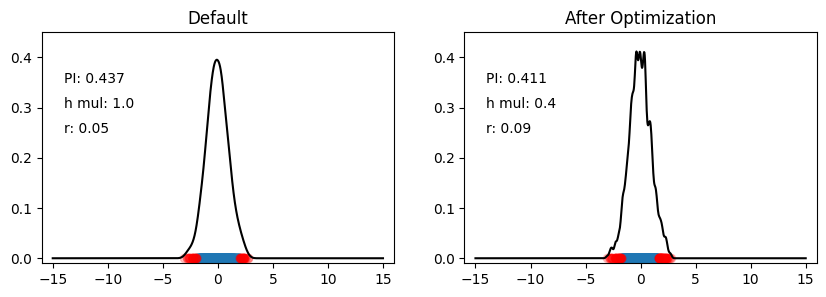

------------------------------
m=1000, (noise) a=10, a/(m+a) = 0.009901


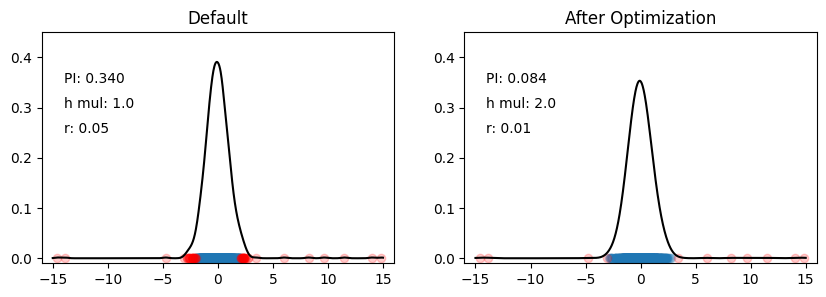

------------------------------
m=1000, (noise) a=20, a/(m+a) = 0.019608


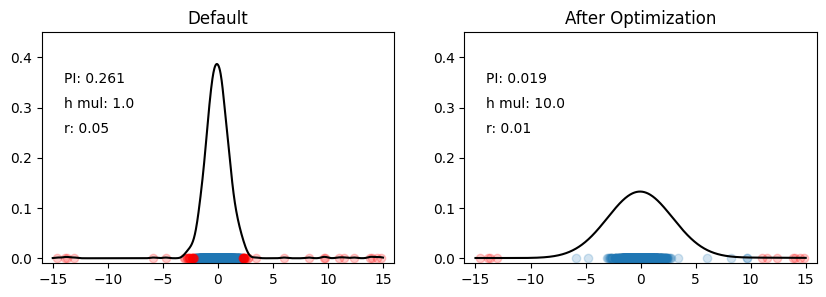

------------------------------
m=1000, (noise) a=50, a/(m+a) = 0.047619


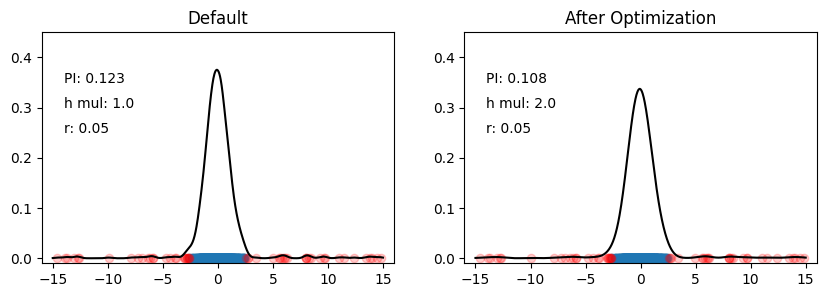

------------------------------
m=1000, (noise) a=100, a/(m+a) = 0.090909


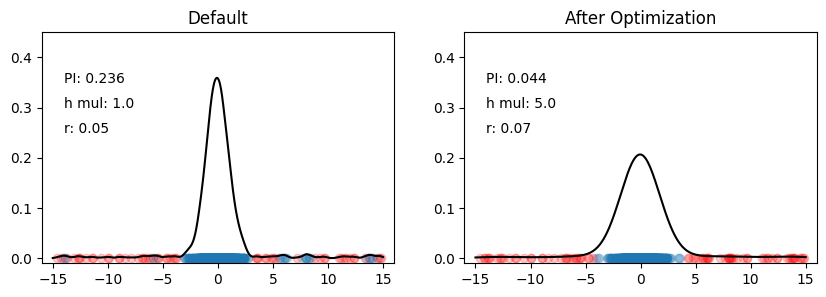

------------------------------
m=1000, (noise) a=200, a/(m+a) = 0.166667


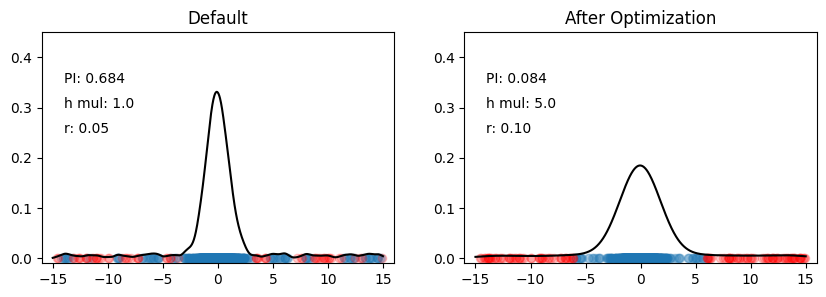

------------------------------
m=1000, (noise) a=500, a/(m+a) = 0.333333


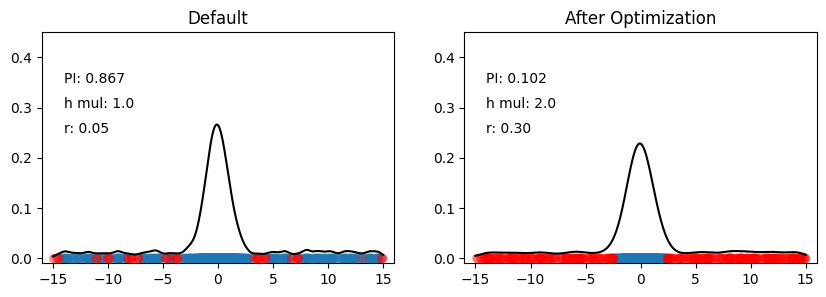

------------------------------
m=1000, (noise) a=1000, a/(m+a) = 0.500000


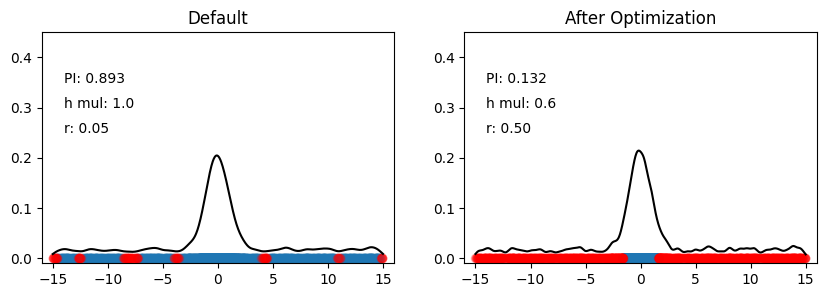

------------------------------


In [7]:
n = 1
m_train1 = 1000
    
h_mul_grid = (1.0, 0.8, 2.0, 0.6, 5.0, 0.4, 10.0, 0.2)
r_grid = (0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5)

for a in [0, 10, 20, 50, 100, 200, 500, 1000]:
    np.random.seed(0)
    print(f"m={m_train1}, (noise) a={a}, a/(m+a) = {a/(a+m_train1):.6f}")
    
    # Data
    x_train1 = np.random.normal(0, 1, size=(m_train1, n))
    x_train2 = np.random.uniform(-15, 15, size=(a, n))
    x_train = np.concatenate((x_train1, x_train2))
    x_grid = np.linspace(-15, 15, 1000)[:, None]
    
    bandwidth = direct_plugin(x_train)

    # Outliers detection
    outliers_detector0 = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth, r=0.05)
    labels_pred0 = outliers_detector0.predict(x_train)
    scores0 = outliers_detector0.kde.pdf(x_grid)
#     metric0 = pi_kf(x_train, labels_pred0, bandwidth=bandwidth)
    scores = outliers_detector0.kde.pdf(x_train)
    inliers = labels_pred0 == 0
    outliers = labels_pred0 == 1
    n_outliers = (outliers == 1).sum()
    scores_out = scores[outliers]
    scores_in = np.sort(scores[inliers])[:n_outliers]
    metric0 = np.sum(scores_out) / np.sum(scores_in)

    # SIATKA - Dopasowanie parametrów na siatce
    
    best_metric = np.inf
    for h_mul in h_mul_grid:
        for r in r_grid:
            kde_outlier_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * h_mul, r=r)
            labels_pred = kde_outlier_detector.predict(x_train)
#             metric = pi_kf(x_train, labels_pred, bandwidth=bandwidth * h_mul)
            scores = kde_outlier_detector.kde.pdf(x_train)
            inliers = labels_pred == 0
            outliers = labels_pred == 1
            n_outliers = (outliers == 1).sum()
            scores_out = scores[outliers]
            scores_in = np.sort(scores[inliers])[:n_outliers]
            metric = np.sum(scores_out) / np.sum(scores_in)
            if metric < best_metric:
                best_h_mul = h_mul
                best_r = r
                best_metric = metric

    # Outliers detection
    outliers_detector1 = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * best_h_mul, r=best_r)
    labels_pred1 = outliers_detector1.predict(x_train)
    scores1 = outliers_detector1.kde.pdf(x_grid)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    
    axs[0].set_title("Default")
    axs[0].plot(x_grid[:, 0], scores0, c="k")
    axs[0].scatter(x_train[labels_pred0==0, 0], x_train[labels_pred0==0, 0]*0, alpha=0.2)
    axs[0].scatter(x_train[labels_pred0==1, 0], x_train[labels_pred0==1, 0]*0, c="red", alpha=0.2)
    axs[0].text(-14, 0.35, f"PI: {metric0:.3f}")
    axs[0].text(-14, 0.3, f"h mul: 1.0")
    axs[0].text(-14, 0.25, f"r: 0.05")
    axs[0].set_xlim(-16, 16)
    axs[0].set_ylim(-0.01, 0.45)
    
    axs[1].set_title("After Optimization")
    axs[1].plot(x_grid[:, 0], scores1, c="k")
    axs[1].scatter(x_train[labels_pred1==0, 0], x_train[labels_pred1==0, 0]*0, alpha=0.2)
    axs[1].scatter(x_train[labels_pred1==1, 0], x_train[labels_pred1==1, 0]*0, c="red", alpha=0.2)
    axs[1].text(-14, 0.35, f"PI: {best_metric:.3f}")
    axs[1].text(-14, 0.3, f"h mul: {best_h_mul:.1f}")
    axs[1].text(-14, 0.25, f"r: {best_r:.2f}")
    axs[1].set_xlim(-16, 16)
    axs[1].set_ylim(-0.01, 0.45)
    
    plt.show()

    print("-" * 30)

\newpage

### Wersja wskaźnika uwzględniająca 1% elementów nietypowych

m=1000, (noise) a=0, a/(m+a) = 0.000000


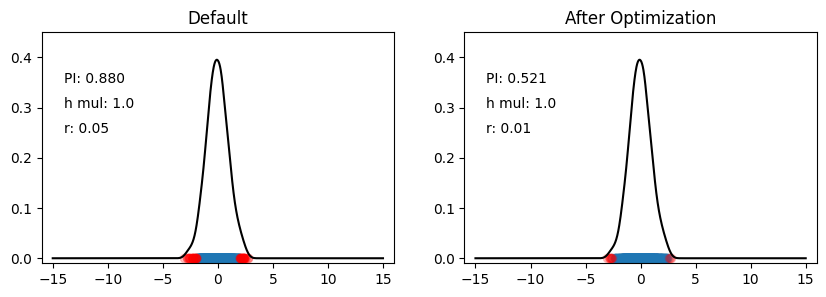

------------------------------
m=1000, (noise) a=10, a/(m+a) = 0.009901


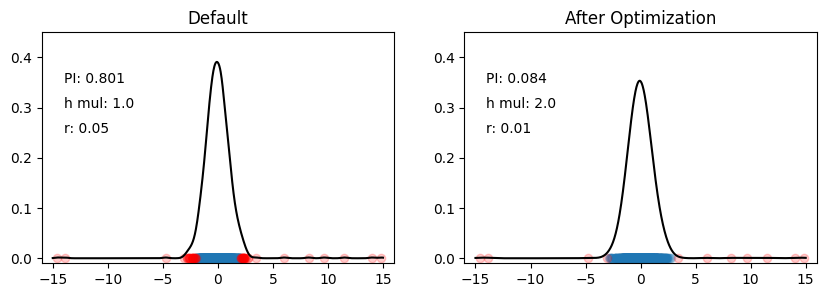

------------------------------
m=1000, (noise) a=20, a/(m+a) = 0.019608


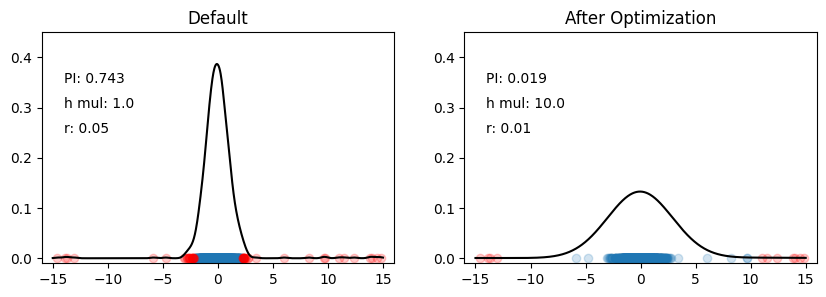

------------------------------
m=1000, (noise) a=50, a/(m+a) = 0.047619


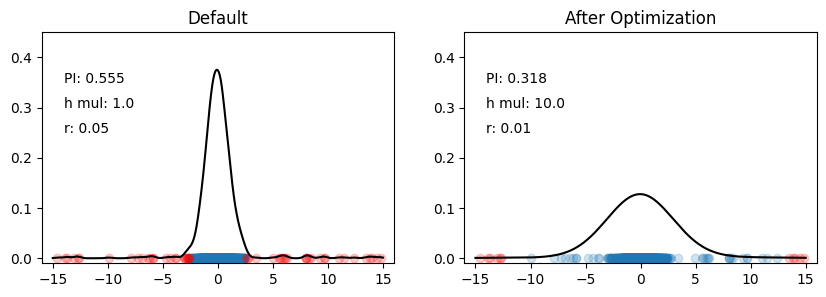

------------------------------
m=1000, (noise) a=100, a/(m+a) = 0.090909


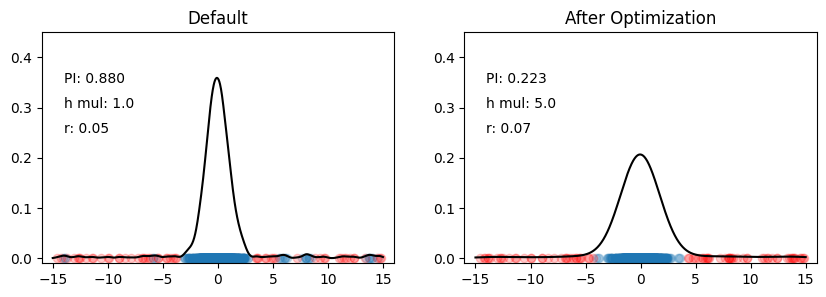

------------------------------
m=1000, (noise) a=200, a/(m+a) = 0.166667


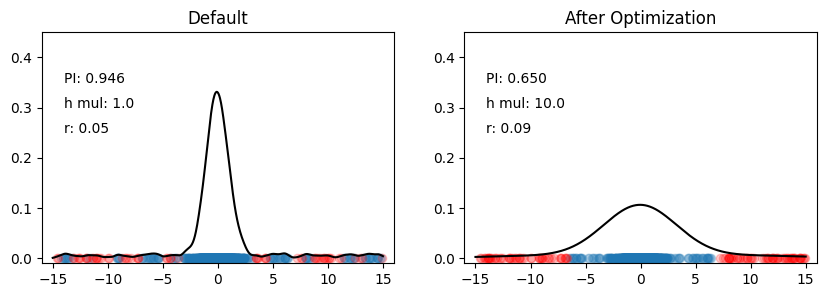

------------------------------
m=1000, (noise) a=500, a/(m+a) = 0.333333


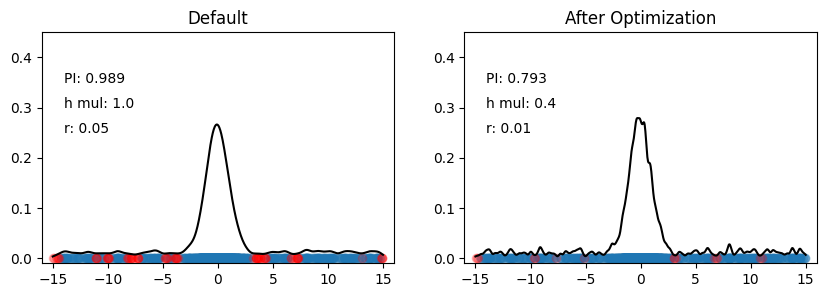

------------------------------
m=1000, (noise) a=1000, a/(m+a) = 0.500000


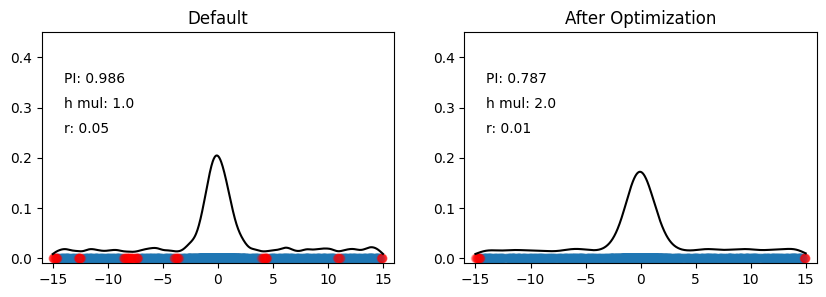

------------------------------


In [8]:
n = 1
m_train1 = 1000
    
h_mul_grid = (1.0, 0.8, 2.0, 0.6, 5.0, 0.4, 10.0, 0.2)
r_grid = (0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5)

for a in [0, 10, 20, 50, 100, 200, 500, 1000]:
    np.random.seed(0)
    print(f"m={m_train1}, (noise) a={a}, a/(m+a) = {a/(a+m_train1):.6f}")
    
    # Data
    x_train1 = np.random.normal(0, 1, size=(m_train1, n))
    x_train2 = np.random.uniform(-15, 15, size=(a, n))
    x_train = np.concatenate((x_train1, x_train2))
    x_grid = np.linspace(-15, 15, 1000)[:, None]
    
    bandwidth = direct_plugin(x_train)

    # Outliers detection
    outliers_detector0 = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth, r=0.05)
    labels_pred0 = outliers_detector0.predict(x_train)
    scores0 = outliers_detector0.kde.pdf(x_grid)
#     metric0 = pi_kf(x_train, labels_pred0, bandwidth=bandwidth)
    scores = outliers_detector0.kde.pdf(x_train)
    inliers = labels_pred0 == 0
    outliers = labels_pred0 == 1
    n_outliers = (outliers == 1).sum()
    n_inliers = (outliers == 0).sum()
    tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
    scores_out = np.sort(scores[outliers])[-tmp:]
    scores_in = np.sort(scores[inliers])[:tmp]
    metric0 = np.sum(scores_out) / np.sum(scores_in)

    # SIATKA - Dopasowanie parametrów na siatce
    
    best_metric = np.inf
    for h_mul in h_mul_grid:
        for r in r_grid:
            kde_outlier_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * h_mul, r=r)
            labels_pred = kde_outlier_detector.predict(x_train)
#             metric = pi_kf(x_train, labels_pred, bandwidth=bandwidth * h_mul)
            scores = kde_outlier_detector.kde.pdf(x_train)
            inliers = labels_pred == 0
            outliers = labels_pred == 1
            n_outliers = (outliers == 1).sum()
            n_inliers = (outliers == 0).sum()
            tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
            scores_out = np.sort(scores[outliers])[-tmp:]
            scores_in = np.sort(scores[inliers])[:tmp]
            metric = np.sum(scores_out) / np.sum(scores_in)
            if metric < best_metric:
                best_h_mul = h_mul
                best_r = r
                best_metric = metric

    # Outliers detection
    outliers_detector1 = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * best_h_mul, r=best_r)
    labels_pred1 = outliers_detector1.predict(x_train)
    scores1 = outliers_detector1.kde.pdf(x_grid)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    
    axs[0].set_title("Default")
    axs[0].plot(x_grid[:, 0], scores0, c="k")
    axs[0].scatter(x_train[labels_pred0==0, 0], x_train[labels_pred0==0, 0]*0, alpha=0.2)
    axs[0].scatter(x_train[labels_pred0==1, 0], x_train[labels_pred0==1, 0]*0, c="red", alpha=0.2)
    axs[0].text(-14, 0.35, f"PI: {metric0:.3f}")
    axs[0].text(-14, 0.3, f"h mul: 1.0")
    axs[0].text(-14, 0.25, f"r: 0.05")
    axs[0].set_xlim(-16, 16)
    axs[0].set_ylim(-0.01, 0.45)
    
    axs[1].set_title("After Optimization")
    axs[1].plot(x_grid[:, 0], scores1, c="k")
    axs[1].scatter(x_train[labels_pred1==0, 0], x_train[labels_pred1==0, 0]*0, alpha=0.2)
    axs[1].scatter(x_train[labels_pred1==1, 0], x_train[labels_pred1==1, 0]*0, c="red", alpha=0.2)
    axs[1].text(-14, 0.35, f"PI: {best_metric:.3f}")
    axs[1].text(-14, 0.3, f"h mul: {best_h_mul:.1f}")
    axs[1].text(-14, 0.25, f"r: {best_r:.2f}")
    axs[1].set_xlim(-16, 16)
    axs[1].set_ylim(-0.01, 0.45)
    
    plt.show()

    print("-" * 30)

\newpage

## Dwumodalny

Zbiór $m=1000$ elementowy wygenerowany z odrębnie (równolicznie) z dwóch rozkładów N(-3,1) i N(3,1) uzupelniony o szum o liczności $a$ wygenerowany z rozkładu jednostajnego w przedziale [-15, 15].

Siatka dla szumu $a$: [0, 10, 20, 50, 100, 200, 500, 1000]

Siatka dla mnożników h: [0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 5.0, 10.0]

Siatka dla r: [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]

\newpage

### Wersja wskaźnika uwzględniająca wszystkie elementy nietypowe

m=1000, (noise) a=0, a/(m+a) = 0.000000


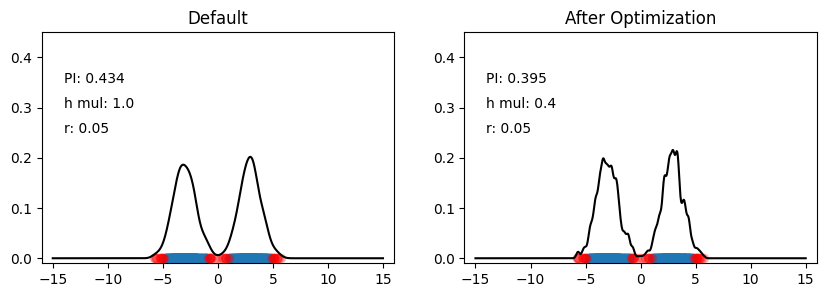

------------------------------
m=1000, (noise) a=10, a/(m+a) = 0.009901


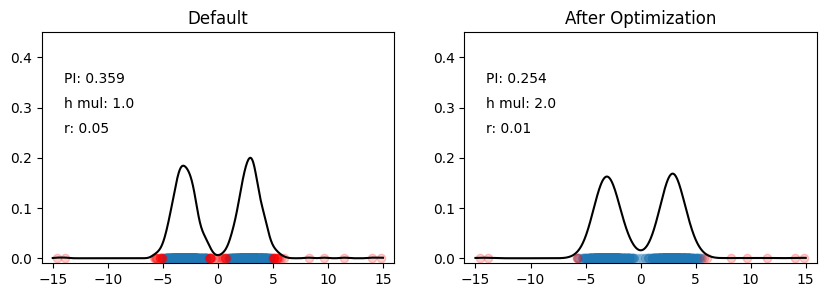

------------------------------
m=1000, (noise) a=20, a/(m+a) = 0.019608


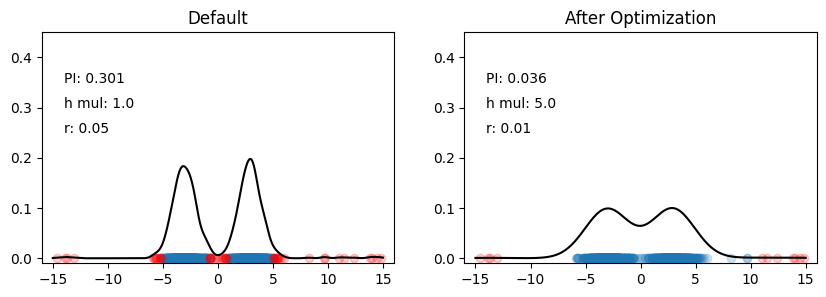

------------------------------
m=1000, (noise) a=50, a/(m+a) = 0.047619


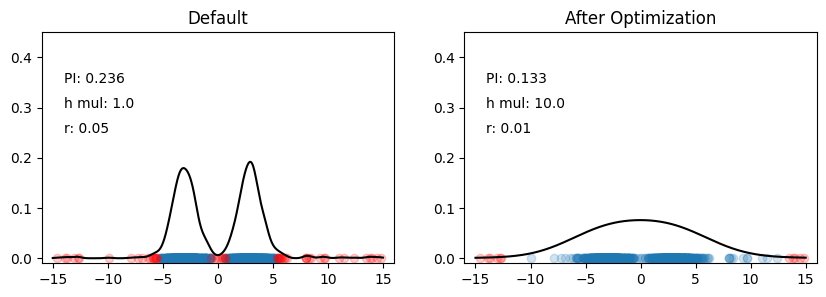

------------------------------
m=1000, (noise) a=100, a/(m+a) = 0.090909


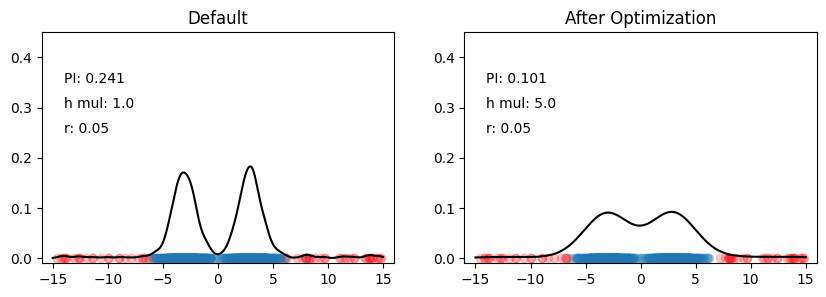

------------------------------
m=1000, (noise) a=200, a/(m+a) = 0.166667


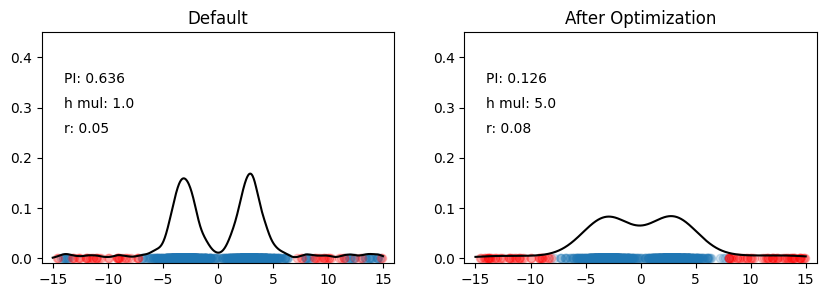

------------------------------
m=1000, (noise) a=500, a/(m+a) = 0.333333


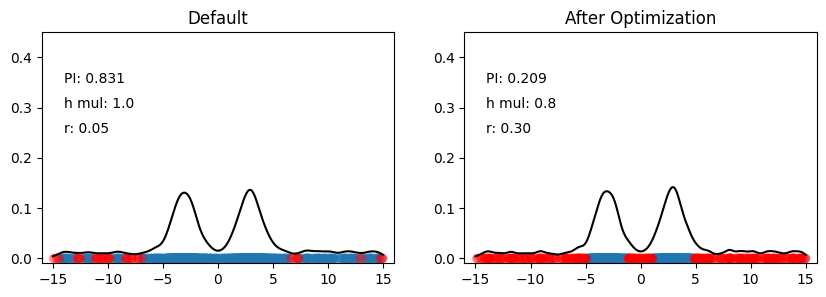

------------------------------
m=1000, (noise) a=1000, a/(m+a) = 0.500000


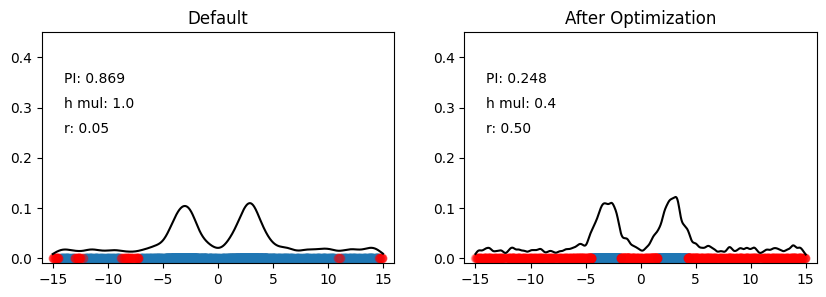

------------------------------


In [9]:
n = 1
m_train1 = 1000
    
h_mul_grid = (1.0, 0.8, 2.0, 0.6, 5.0, 0.4, 10.0, 0.2)
r_grid = (0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5)

for a in [0, 10, 20, 50, 100, 200, 500, 1000]:
    np.random.seed(0)
    print(f"m={m_train1}, (noise) a={a}, a/(m+a) = {a/(a+m_train1):.6f}")
    
    # Data
    x_train1 = np.random.normal(-3, 1, size=(m_train1//2, n))
    x_train2 = np.random.normal(3, 1, size=(m_train1//2, n))
    x_train3 = np.random.uniform(-15, 15, size=(a, n))
    x_train = np.concatenate((x_train1, x_train2, x_train3))
    x_grid = np.linspace(-15, 15, 1000)[:, None]
    
    bandwidth = direct_plugin(x_train)

    # Outliers detection
    outliers_detector0 = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth, r=0.05)
    labels_pred0 = outliers_detector0.predict(x_train)
    scores0 = outliers_detector0.kde.pdf(x_grid)
#     metric0 = pi_kf(x_train, labels_pred0, bandwidth=bandwidth)
    scores = outliers_detector0.kde.pdf(x_train)
    inliers = labels_pred0 == 0
    outliers = labels_pred0 == 1
    n_outliers = (outliers == 1).sum()
    scores_out = scores[outliers]
    scores_in = np.sort(scores[inliers])[:n_outliers]
    metric0 = np.sum(scores_out) / np.sum(scores_in)

    # SIATKA - Dopasowanie parametrów na siatce
    
    best_metric = np.inf
    for h_mul in h_mul_grid:
        for r in r_grid:
            kde_outlier_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * h_mul, r=r)
            labels_pred = kde_outlier_detector.predict(x_train)
#             metric = pi_kf(x_train, labels_pred, bandwidth=bandwidth * h_mul)
            scores = kde_outlier_detector.kde.pdf(x_train)
            inliers = labels_pred == 0
            outliers = labels_pred == 1
            n_outliers = (outliers == 1).sum()
            scores_out = scores[outliers]
            scores_in = np.sort(scores[inliers])[:n_outliers]
            metric = np.sum(scores_out) / np.sum(scores_in)
            if metric < best_metric:
                best_h_mul = h_mul
                best_r = r
                best_metric = metric

    # Outliers detection
    outliers_detector1 = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * best_h_mul, r=best_r)
    labels_pred1 = outliers_detector1.predict(x_train)
    scores1 = outliers_detector1.kde.pdf(x_grid)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    
    axs[0].set_title("Default")
    axs[0].plot(x_grid[:, 0], scores0, c="k")
    axs[0].scatter(x_train[labels_pred0==0, 0], x_train[labels_pred0==0, 0]*0, alpha=0.2)
    axs[0].scatter(x_train[labels_pred0==1, 0], x_train[labels_pred0==1, 0]*0, c="red", alpha=0.2)
    axs[0].text(-14, 0.35, f"PI: {metric0:.3f}")
    axs[0].text(-14, 0.3, f"h mul: 1.0")
    axs[0].text(-14, 0.25, f"r: 0.05")
    axs[0].set_xlim(-16, 16)
    axs[0].set_ylim(-0.01, 0.45)
    
    axs[1].set_title("After Optimization")
    axs[1].plot(x_grid[:, 0], scores1, c="k")
    axs[1].scatter(x_train[labels_pred1==0, 0], x_train[labels_pred1==0, 0]*0, alpha=0.2)
    axs[1].scatter(x_train[labels_pred1==1, 0], x_train[labels_pred1==1, 0]*0, c="red", alpha=0.2)
    axs[1].text(-14, 0.35, f"PI: {best_metric:.3f}")
    axs[1].text(-14, 0.3, f"h mul: {best_h_mul:.1f}")
    axs[1].text(-14, 0.25, f"r: {best_r:.2f}")
    axs[1].set_xlim(-16, 16)
    axs[1].set_ylim(-0.01, 0.45)
    
    plt.show()

    print("-" * 30)

\newpage

### Wersja wskaźnika uwzględniająca 1% elementów nietypowych

m=1000, (noise) a=0, a/(m+a) = 0.000000


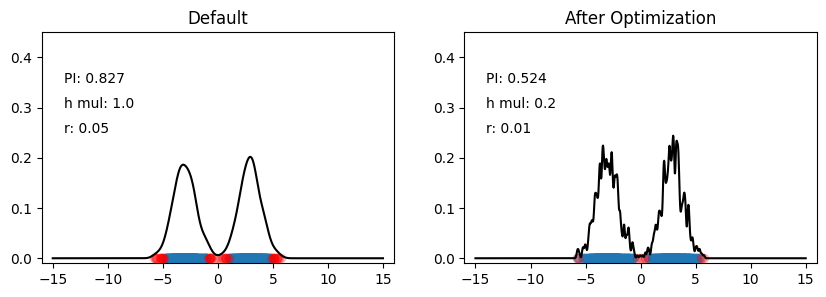

------------------------------
m=1000, (noise) a=10, a/(m+a) = 0.009901


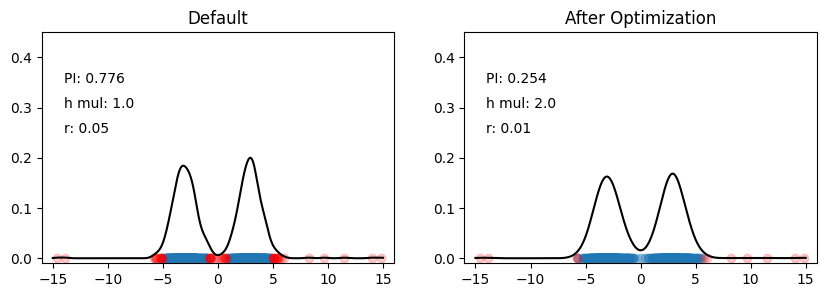

------------------------------
m=1000, (noise) a=20, a/(m+a) = 0.019608


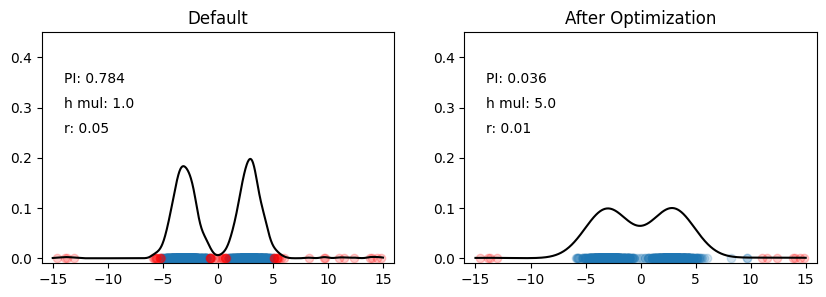

------------------------------
m=1000, (noise) a=50, a/(m+a) = 0.047619


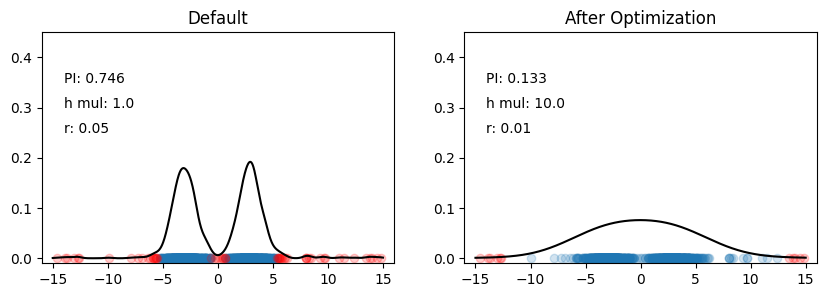

------------------------------
m=1000, (noise) a=100, a/(m+a) = 0.090909


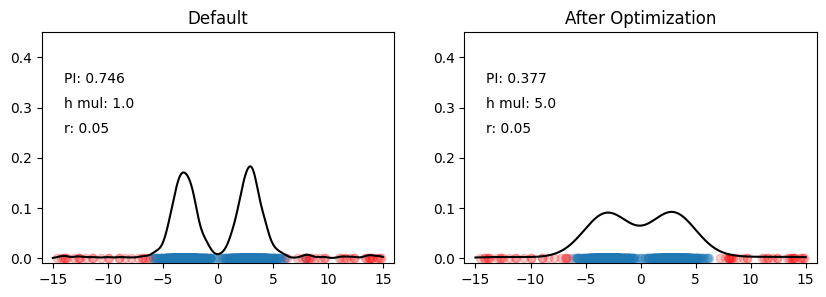

------------------------------
m=1000, (noise) a=200, a/(m+a) = 0.166667


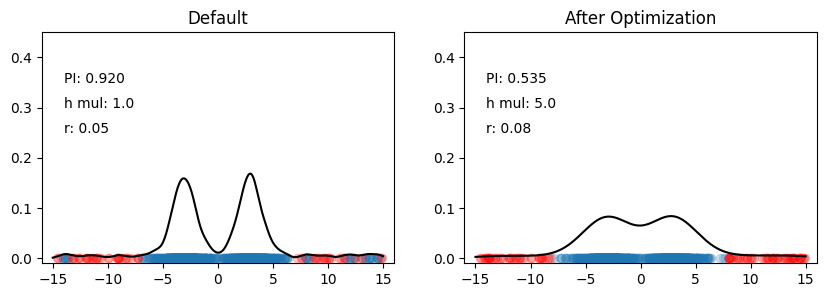

------------------------------
m=1000, (noise) a=500, a/(m+a) = 0.333333


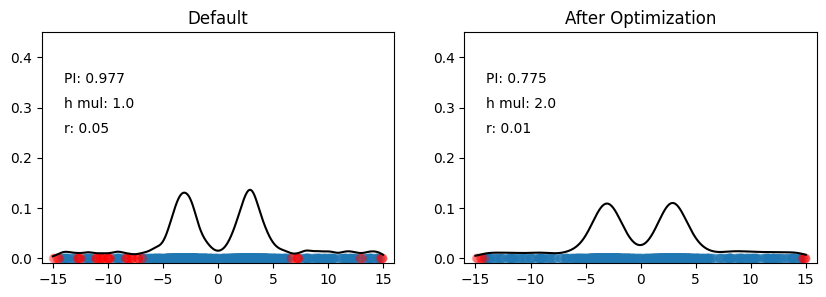

------------------------------
m=1000, (noise) a=1000, a/(m+a) = 0.500000


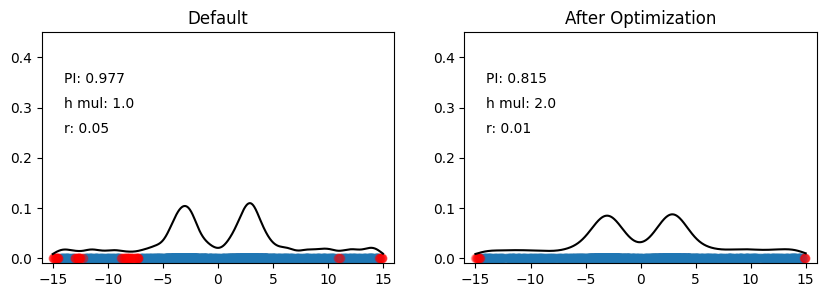

------------------------------


In [10]:
n = 1
m_train1 = 1000
    
h_mul_grid = (1.0, 0.8, 2.0, 0.6, 5.0, 0.4, 10.0, 0.2)
r_grid = (0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5)

for a in [0, 10, 20, 50, 100, 200, 500, 1000]:
    np.random.seed(0)
    print(f"m={m_train1}, (noise) a={a}, a/(m+a) = {a/(a+m_train1):.6f}")
    
    # Data
    x_train1 = np.random.normal(-3, 1, size=(m_train1//2, n))
    x_train2 = np.random.normal(3, 1, size=(m_train1//2, n))
    x_train3 = np.random.uniform(-15, 15, size=(a, n))
    x_train = np.concatenate((x_train1, x_train2, x_train3))
    x_grid = np.linspace(-15, 15, 1000)[:, None]
    
    bandwidth = direct_plugin(x_train)

    # Outliers detection
    outliers_detector0 = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth, r=0.05)
    labels_pred0 = outliers_detector0.predict(x_train)
    scores0 = outliers_detector0.kde.pdf(x_grid)
#     metric0 = pi_kf(x_train, labels_pred0, bandwidth=bandwidth)
    scores = outliers_detector0.kde.pdf(x_train)
    inliers = labels_pred0 == 0
    outliers = labels_pred0 == 1
    n_outliers = (outliers == 1).sum()
    n_inliers = (outliers == 0).sum()
    tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
    scores_out = np.sort(scores[outliers])[-tmp:]
    scores_in = np.sort(scores[inliers])[:tmp]
    metric0 = np.sum(scores_out) / np.sum(scores_in)

    # SIATKA - Dopasowanie parametrów na siatce
    
    best_metric = np.inf
    for h_mul in h_mul_grid:
        for r in r_grid:
            kde_outlier_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * h_mul, r=r)
            labels_pred = kde_outlier_detector.predict(x_train)
#             metric = pi_kf(x_train, labels_pred, bandwidth=bandwidth * h_mul)
            scores = kde_outlier_detector.kde.pdf(x_train)
            inliers = labels_pred == 0
            outliers = labels_pred == 1
            n_outliers = (outliers == 1).sum()
            n_inliers = (outliers == 0).sum()
            tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
            scores_out = np.sort(scores[outliers])[-tmp:]
            scores_in = np.sort(scores[inliers])[:tmp]
            metric = np.sum(scores_out) / np.sum(scores_in)
            if metric < best_metric:
                best_h_mul = h_mul
                best_r = r
                best_metric = metric

    # Outliers detection
    outliers_detector1 = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * best_h_mul, r=best_r)
    labels_pred1 = outliers_detector1.predict(x_train)
    scores1 = outliers_detector1.kde.pdf(x_grid)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    
    axs[0].set_title("Default")
    axs[0].plot(x_grid[:, 0], scores0, c="k")
    axs[0].scatter(x_train[labels_pred0==0, 0], x_train[labels_pred0==0, 0]*0, alpha=0.2)
    axs[0].scatter(x_train[labels_pred0==1, 0], x_train[labels_pred0==1, 0]*0, c="red", alpha=0.2)
    axs[0].text(-14, 0.35, f"PI: {metric0:.3f}")
    axs[0].text(-14, 0.3, f"h mul: 1.0")
    axs[0].text(-14, 0.25, f"r: 0.05")
    axs[0].set_xlim(-16, 16)
    axs[0].set_ylim(-0.01, 0.45)
    
    axs[1].set_title("After Optimization")
    axs[1].plot(x_grid[:, 0], scores1, c="k")
    axs[1].scatter(x_train[labels_pred1==0, 0], x_train[labels_pred1==0, 0]*0, alpha=0.2)
    axs[1].scatter(x_train[labels_pred1==1, 0], x_train[labels_pred1==1, 0]*0, c="red", alpha=0.2)
    axs[1].text(-14, 0.35, f"PI: {best_metric:.3f}")
    axs[1].text(-14, 0.3, f"h mul: {best_h_mul:.1f}")
    axs[1].text(-14, 0.25, f"r: {best_r:.2f}")
    axs[1].set_xlim(-16, 16)
    axs[1].set_ylim(-0.01, 0.45)
    
    plt.show()

    print("-" * 30)

\newpage

# 2d

## Jednomodalny

Zbiór $m=1000$ elementowy wygenerowany z rozkładu N([0,0],[[1,0],[0,1]]) uzupelniony o szum o liczności $a$ wygenerowany z rozkładu jednostajnego w przedziale [-10, 10].

Siatka dla szumu $a$: [0, 10, 20, 50, 100, 200, 500, 1000]

Siatka dla mnożników h: [0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 5.0, 10.0]

Siatka dla r: [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]

\newpage

### Wersja wskaźnika uwzględniająca wszystkie elementy nietypowe

m=1000, (noise) a=0, a/(m+a) = 0.000000


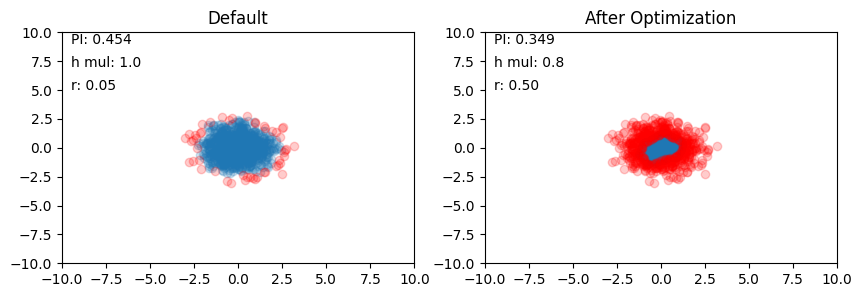

------------------------------
m=1000, (noise) a=10, a/(m+a) = 0.009901


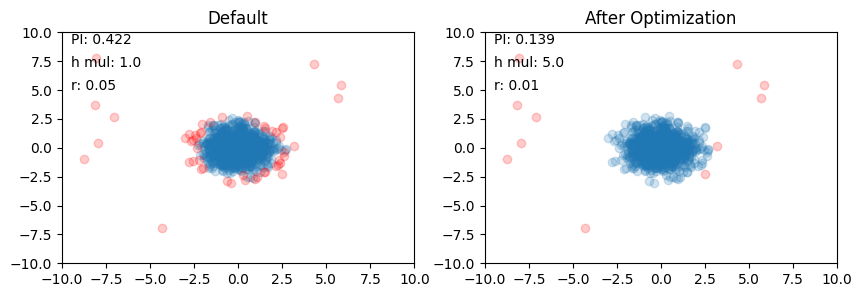

------------------------------
m=1000, (noise) a=20, a/(m+a) = 0.019608


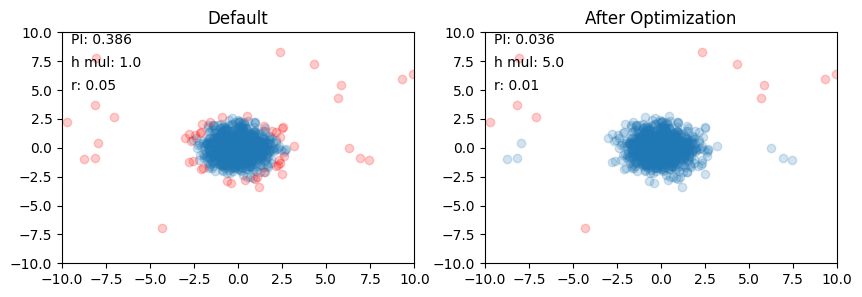

------------------------------
m=1000, (noise) a=50, a/(m+a) = 0.047619


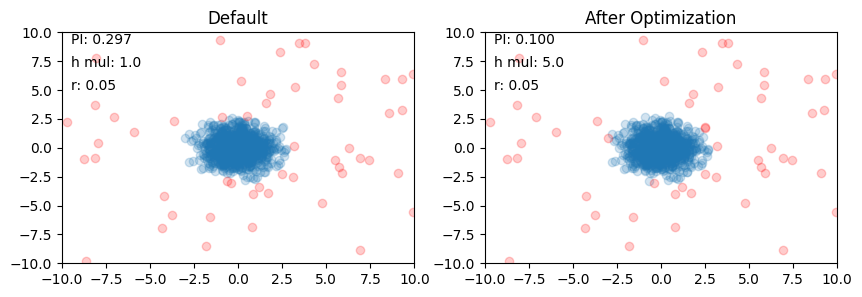

------------------------------
m=1000, (noise) a=100, a/(m+a) = 0.090909


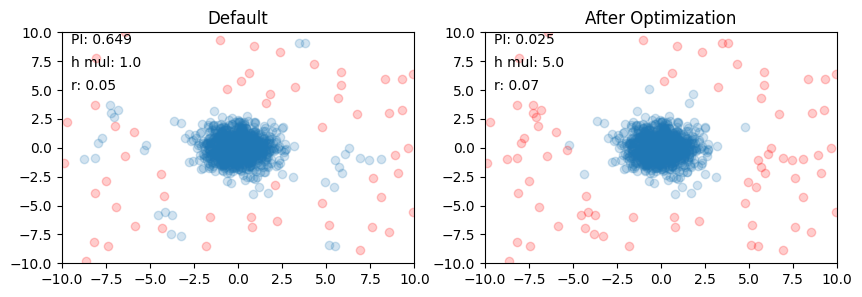

------------------------------
m=1000, (noise) a=200, a/(m+a) = 0.166667


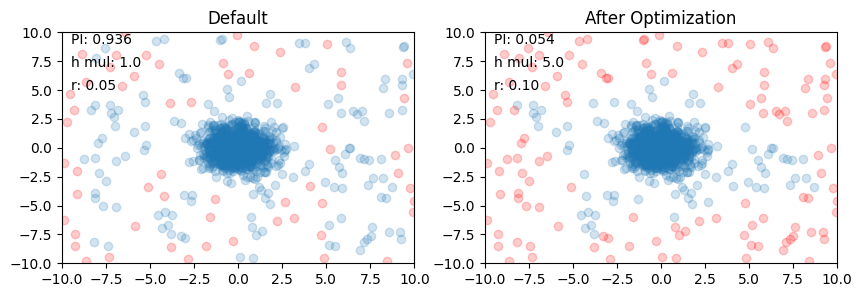

------------------------------
m=1000, (noise) a=500, a/(m+a) = 0.333333


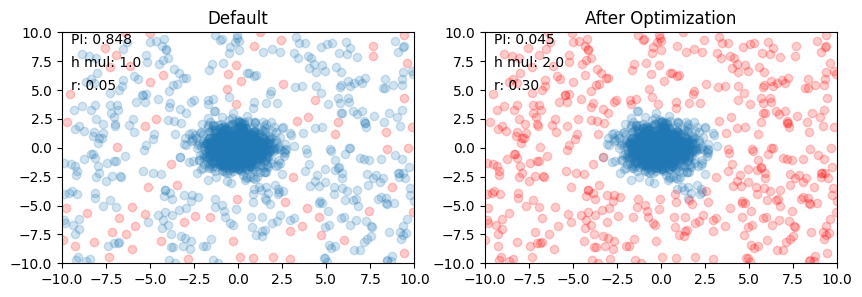

------------------------------
m=1000, (noise) a=1000, a/(m+a) = 0.500000


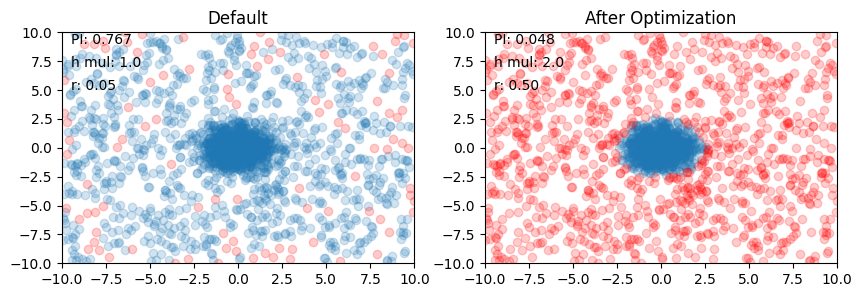

------------------------------


In [11]:
n = 2
m_train1 = 1000
    
h_mul_grid = (1.0, 0.8, 2.0, 0.6, 5.0, 0.4, 10.0, 0.2)
r_grid = (0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5)

for a in [0, 10, 20, 50, 100, 200, 500, 1000]:
    np.random.seed(0)
    print(f"m={m_train1}, (noise) a={a}, a/(m+a) = {a/(a+m_train1):.6f}")
    
    # Data
    x_train1 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], size=m_train1)
    x_train2 = np.random.uniform(-10, 10, size=(a, n))
    x_train = np.concatenate((x_train1, x_train2))
    
    bandwidth = direct_plugin(x_train)

    # Outliers detection
    outliers_detector0 = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth, r=0.05)
    labels_pred0 = outliers_detector0.predict(x_train)
    scores0 = outliers_detector0.kde.pdf(x_grid)
#     metric0 = pi_kf(x_train, labels_pred0, bandwidth=bandwidth)
    scores = outliers_detector0.kde.pdf(x_train)
    inliers = labels_pred0 == 0
    outliers = labels_pred0 == 1
    n_outliers = (outliers == 1).sum()
    scores_out = scores[outliers]
    scores_in = np.sort(scores[inliers])[:n_outliers]
    metric0 = np.sum(scores_out) / np.sum(scores_in)

    # SIATKA - Dopasowanie parametrów na siatce
    
    best_metric = np.inf
    for h_mul in h_mul_grid:
        for r in r_grid:
            kde_outlier_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * h_mul, r=r)
            labels_pred = kde_outlier_detector.predict(x_train)
#             metric = pi_kf(x_train, labels_pred, bandwidth=bandwidth * h_mul)
            scores = kde_outlier_detector.kde.pdf(x_train)
            inliers = labels_pred == 0
            outliers = labels_pred == 1
            n_outliers = (outliers == 1).sum()
            scores_out = scores[outliers]
            scores_in = np.sort(scores[inliers])[:n_outliers]
            metric = np.sum(scores_out) / np.sum(scores_in)
            if metric < best_metric:
                best_h_mul = h_mul
                best_r = r
                best_metric = metric

    # Outliers detection
    outliers_detector1 = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * best_h_mul, r=best_r)
    labels_pred1 = outliers_detector1.predict(x_train)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    
    axs[0].set_title("Default")
    axs[0].scatter(x_train[labels_pred0==0, 0], x_train[labels_pred0==0, 1], alpha=0.2)
    axs[0].scatter(x_train[labels_pred0==1, 0], x_train[labels_pred0==1, 1], c="red", alpha=0.2)
    axs[0].text(-9.5, 9, f"PI: {metric0:.3f}")
    axs[0].text(-9.5, 7, f"h mul: 1.0")
    axs[0].text(-9.5, 5, f"r: 0.05")
    axs[0].set_xlim(-10, 10)
    axs[0].set_ylim(-10, 10)
    
    axs[1].set_title("After Optimization")
    axs[1].scatter(x_train[labels_pred1==0, 0], x_train[labels_pred1==0, 1], alpha=0.2)
    axs[1].scatter(x_train[labels_pred1==1, 0], x_train[labels_pred1==1, 1], c="red", alpha=0.2)
    axs[1].text(-9.5, 9, f"PI: {best_metric:.3f}")
    axs[1].text(-9.5, 7, f"h mul: {best_h_mul:.1f}")
    axs[1].text(-9.5, 5, f"r: {best_r:.2f}")
    axs[1].set_xlim(-10, 10)
    axs[1].set_ylim(-10, 10)
    
    plt.show()

    print("-" * 30)

\newpage

### Wersja wskaźnika uwzględniająca 1% elementów nietypowych

m=1000, (noise) a=0, a/(m+a) = 0.000000


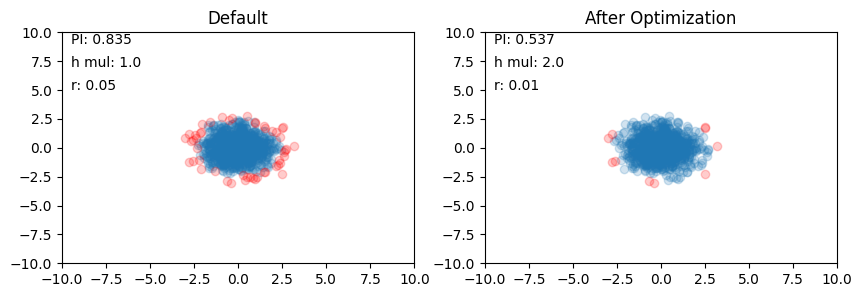

------------------------------
m=1000, (noise) a=10, a/(m+a) = 0.009901


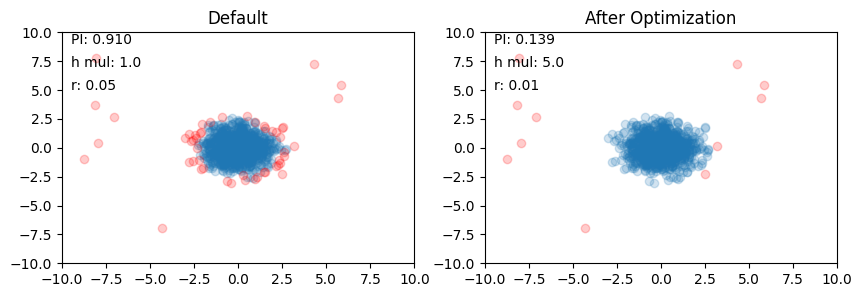

------------------------------
m=1000, (noise) a=20, a/(m+a) = 0.019608


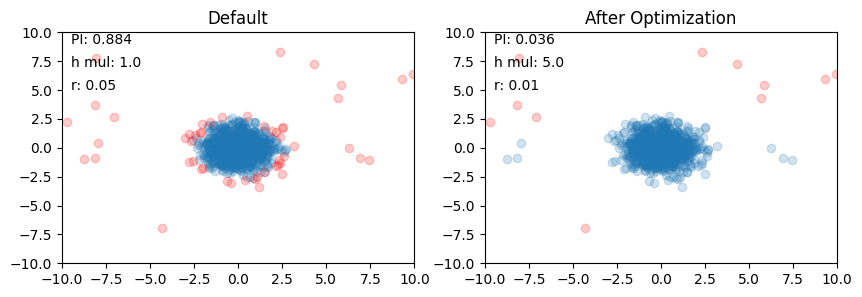

------------------------------
m=1000, (noise) a=50, a/(m+a) = 0.047619


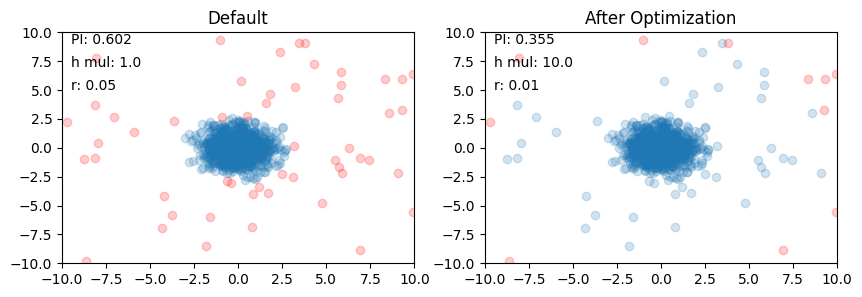

------------------------------
m=1000, (noise) a=100, a/(m+a) = 0.090909


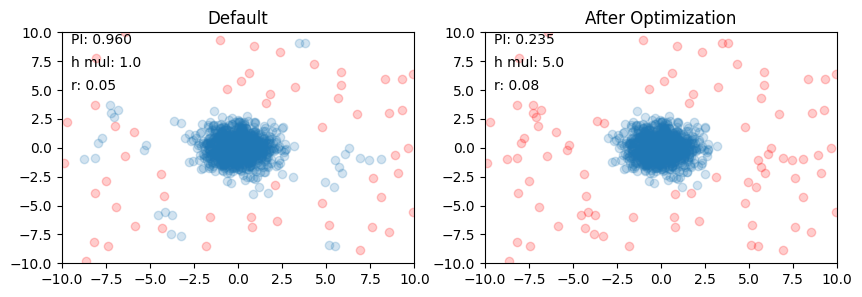

------------------------------
m=1000, (noise) a=200, a/(m+a) = 0.166667


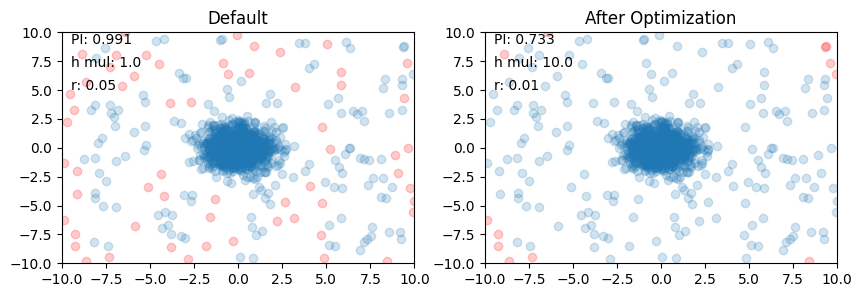

------------------------------
m=1000, (noise) a=500, a/(m+a) = 0.333333


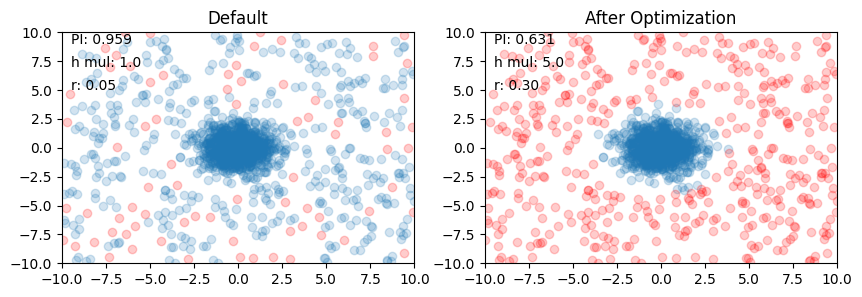

------------------------------
m=1000, (noise) a=1000, a/(m+a) = 0.500000


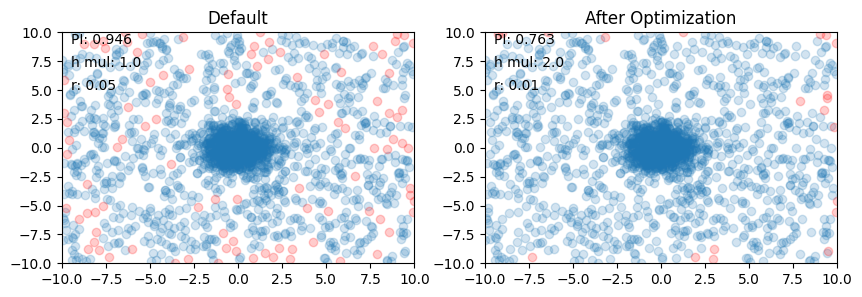

------------------------------


In [12]:
n = 2
m_train1 = 1000
    
h_mul_grid = (1.0, 0.8, 2.0, 0.6, 5.0, 0.4, 10.0, 0.2)
r_grid = (0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5)

for a in [0, 10, 20, 50, 100, 200, 500, 1000]:
    np.random.seed(0)
    print(f"m={m_train1}, (noise) a={a}, a/(m+a) = {a/(a+m_train1):.6f}")
    
    # Data
    x_train1 = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], size=m_train1)
    x_train2 = np.random.uniform(-10, 10, size=(a, n))
    x_train = np.concatenate((x_train1, x_train2))
    
    bandwidth = direct_plugin(x_train)

    # Outliers detection
    outliers_detector0 = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth, r=0.05)
    labels_pred0 = outliers_detector0.predict(x_train)
    scores0 = outliers_detector0.kde.pdf(x_grid)
#     metric0 = pi_kf(x_train, labels_pred0, bandwidth=bandwidth)
    scores = outliers_detector0.kde.pdf(x_train)
    inliers = labels_pred0 == 0
    outliers = labels_pred0 == 1
    n_outliers = (outliers == 1).sum()
    n_inliers = (outliers == 0).sum()
    tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
    scores_out = np.sort(scores[outliers])[-tmp:]
    scores_in = np.sort(scores[inliers])[:tmp]
    metric0 = np.sum(scores_out) / np.sum(scores_in)

    # SIATKA - Dopasowanie parametrów na siatce
    
    best_metric = np.inf
    for h_mul in h_mul_grid:
        for r in r_grid:
            kde_outlier_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * h_mul, r=r)
            labels_pred = kde_outlier_detector.predict(x_train)
#             metric = pi_kf(x_train, labels_pred, bandwidth=bandwidth * h_mul)
            scores = kde_outlier_detector.kde.pdf(x_train)
            inliers = labels_pred == 0
            outliers = labels_pred == 1
            n_outliers = (outliers == 1).sum()
            n_inliers = (outliers == 0).sum()
            tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
            scores_out = np.sort(scores[outliers])[-tmp:]
            scores_in = np.sort(scores[inliers])[:tmp]
            metric = np.sum(scores_out) / np.sum(scores_in)
            if metric < best_metric:
                best_h_mul = h_mul
                best_r = r
                best_metric = metric

    # Outliers detection
    outliers_detector1 = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * best_h_mul, r=best_r)
    labels_pred1 = outliers_detector1.predict(x_train)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    
    axs[0].set_title("Default")
    axs[0].scatter(x_train[labels_pred0==0, 0], x_train[labels_pred0==0, 1], alpha=0.2)
    axs[0].scatter(x_train[labels_pred0==1, 0], x_train[labels_pred0==1, 1], c="red", alpha=0.2)
    axs[0].text(-9.5, 9, f"PI: {metric0:.3f}")
    axs[0].text(-9.5, 7, f"h mul: 1.0")
    axs[0].text(-9.5, 5, f"r: 0.05")
    axs[0].set_xlim(-10, 10)
    axs[0].set_ylim(-10, 10)
    
    axs[1].set_title("After Optimization")
    axs[1].scatter(x_train[labels_pred1==0, 0], x_train[labels_pred1==0, 1], alpha=0.2)
    axs[1].scatter(x_train[labels_pred1==1, 0], x_train[labels_pred1==1, 1], c="red", alpha=0.2)
    axs[1].text(-9.5, 9, f"PI: {best_metric:.3f}")
    axs[1].text(-9.5, 7, f"h mul: {best_h_mul:.1f}")
    axs[1].text(-9.5, 5, f"r: {best_r:.2f}")
    axs[1].set_xlim(-10, 10)
    axs[1].set_ylim(-10, 10)
    
    plt.show()

    print("-" * 30)

\newpage

## Dwumodalny

Zbiór $m=1000$ elementowy wygenerowany z odrębnie (równolicznie) z dwóch rozkładów N([-2,-2],[[1, 0], [0, 1]]) i N([2,2],[[1, 0], [0, 1]]) uzupelniony o szum o liczności $a$ wygenerowany z rozkładu jednostajnego w przedziale [-10, 10].

Siatka dla szumu $a$: [0, 10, 20, 50, 100, 200, 500, 1000]

Siatka dla mnożników h: [0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 5.0, 10.0]

Siatka dla r: [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]

\newpage

### Wersja wskaźnika uwzględniająca wszystkie elementy nietypowe

m=1000, (noise) a=0, a/(m+a) = 0.000000


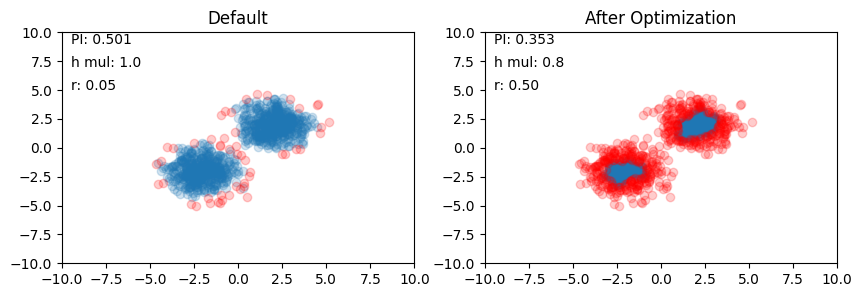

------------------------------
m=1000, (noise) a=10, a/(m+a) = 0.009901


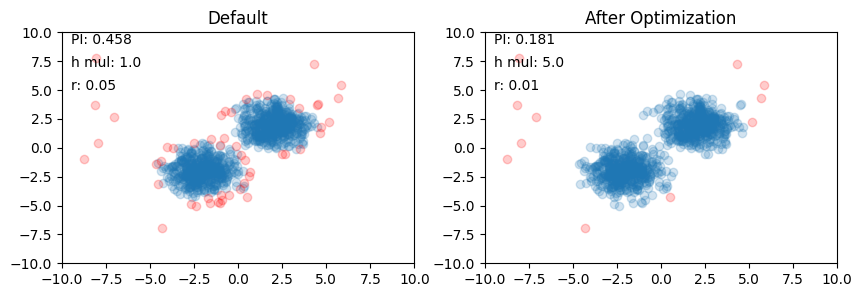

------------------------------
m=1000, (noise) a=20, a/(m+a) = 0.019608


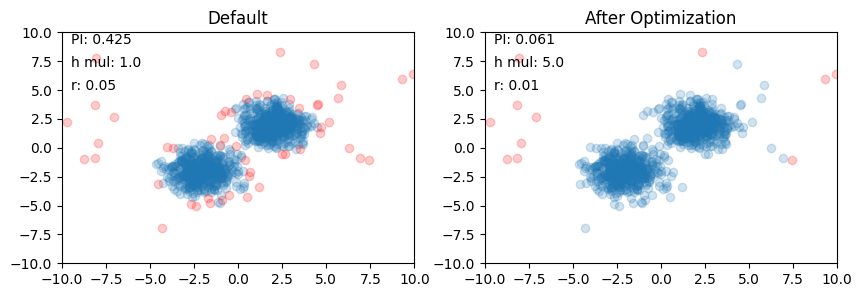

------------------------------
m=1000, (noise) a=50, a/(m+a) = 0.047619


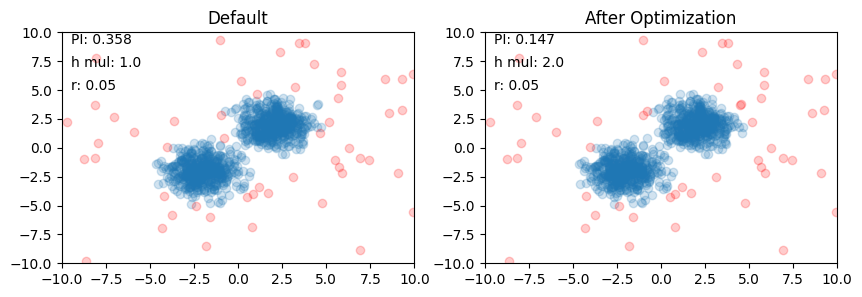

------------------------------
m=1000, (noise) a=100, a/(m+a) = 0.090909


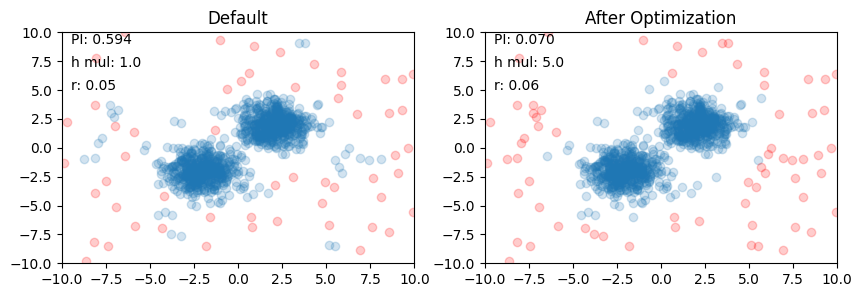

------------------------------
m=1000, (noise) a=200, a/(m+a) = 0.166667


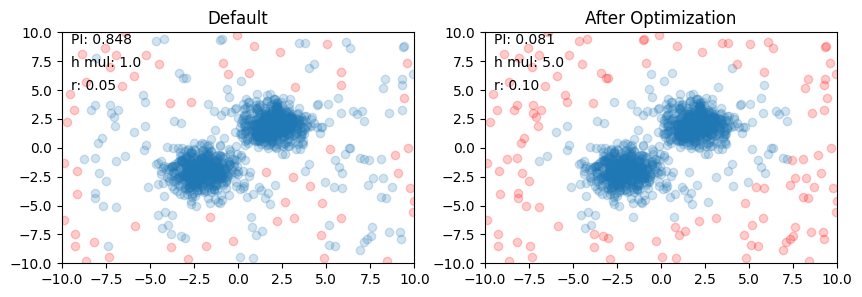

------------------------------
m=1000, (noise) a=500, a/(m+a) = 0.333333


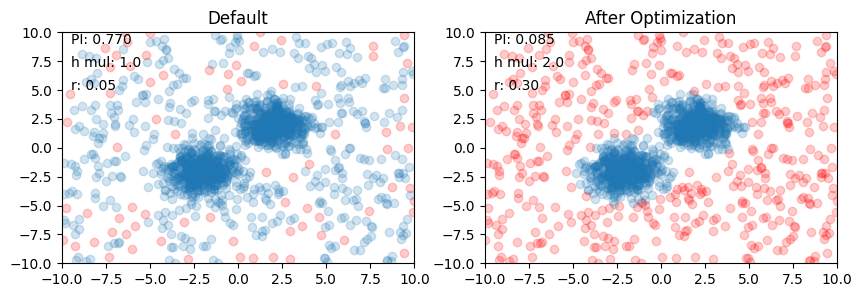

------------------------------
m=1000, (noise) a=1000, a/(m+a) = 0.500000


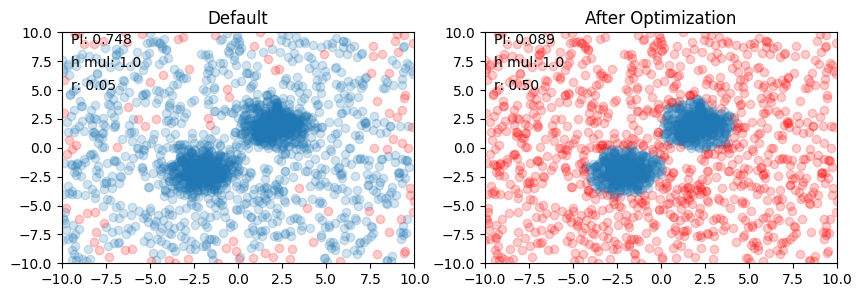

------------------------------


In [13]:
n = 2
m_train1 = 1000
    
h_mul_grid = (1.0, 0.8, 2.0, 0.6, 5.0, 0.4, 10.0, 0.2)
r_grid = (0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5)

for a in [0, 10, 20, 50, 100, 200, 500, 1000]:
    np.random.seed(0)
    print(f"m={m_train1}, (noise) a={a}, a/(m+a) = {a/(a+m_train1):.6f}")
    
    # Data
    x_train1 = np.random.multivariate_normal([-2, -2], [[1, 0], [0, 1]], size=m_train1//2)
    x_train2 = np.random.multivariate_normal([2, 2], [[1, 0], [0, 1]], size=m_train1//2)
    x_train3 = np.random.uniform(-10, 10, size=(a, n))
    x_train = np.concatenate((x_train1, x_train2, x_train3))
    
    bandwidth = direct_plugin(x_train)

    # Outliers detection
    outliers_detector0 = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth, r=0.05)
    labels_pred0 = outliers_detector0.predict(x_train)
    scores0 = outliers_detector0.kde.pdf(x_grid)
#     metric0 = pi_kf(x_train, labels_pred0, bandwidth=bandwidth)
    scores = outliers_detector0.kde.pdf(x_train)
    inliers = labels_pred0 == 0
    outliers = labels_pred0 == 1
    n_outliers = (outliers == 1).sum()
    scores_out = scores[outliers]
    scores_in = np.sort(scores[inliers])[:n_outliers]
    metric0 = np.sum(scores_out) / np.sum(scores_in)

    # SIATKA - Dopasowanie parametrów na siatce
    
    best_metric = np.inf
    for h_mul in h_mul_grid:
        for r in r_grid:
            kde_outlier_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * h_mul, r=r)
            labels_pred = kde_outlier_detector.predict(x_train)
#             metric = pi_kf(x_train, labels_pred, bandwidth=bandwidth * h_mul)
            scores = kde_outlier_detector.kde.pdf(x_train)
            inliers = labels_pred == 0
            outliers = labels_pred == 1
            n_outliers = (outliers == 1).sum()
            scores_out = scores[outliers]
            scores_in = np.sort(scores[inliers])[:n_outliers]
            metric = np.sum(scores_out) / np.sum(scores_in)
            if metric < best_metric:
                best_h_mul = h_mul
                best_r = r
                best_metric = metric

    # Outliers detection
    outliers_detector1 = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * best_h_mul, r=best_r)
    labels_pred1 = outliers_detector1.predict(x_train)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    
    axs[0].set_title("Default")
    axs[0].scatter(x_train[labels_pred0==0, 0], x_train[labels_pred0==0, 1], alpha=0.2)
    axs[0].scatter(x_train[labels_pred0==1, 0], x_train[labels_pred0==1, 1], c="red", alpha=0.2)
    axs[0].text(-9.5, 9, f"PI: {metric0:.3f}")
    axs[0].text(-9.5, 7, f"h mul: 1.0")
    axs[0].text(-9.5, 5, f"r: 0.05")
    axs[0].set_xlim(-10, 10)
    axs[0].set_ylim(-10, 10)
    
    axs[1].set_title("After Optimization")
    axs[1].scatter(x_train[labels_pred1==0, 0], x_train[labels_pred1==0, 1], alpha=0.2)
    axs[1].scatter(x_train[labels_pred1==1, 0], x_train[labels_pred1==1, 1], c="red", alpha=0.2)
    axs[1].text(-9.5, 9, f"PI: {best_metric:.3f}")
    axs[1].text(-9.5, 7, f"h mul: {best_h_mul:.1f}")
    axs[1].text(-9.5, 5, f"r: {best_r:.2f}")
    axs[1].set_xlim(-10, 10)
    axs[1].set_ylim(-10, 10)
    
    plt.show()

    print("-" * 30)

\newpage

### Wersja wskaźnika uwzględniająca 1% elementów nietypowych

m=1000, (noise) a=0, a/(m+a) = 0.000000


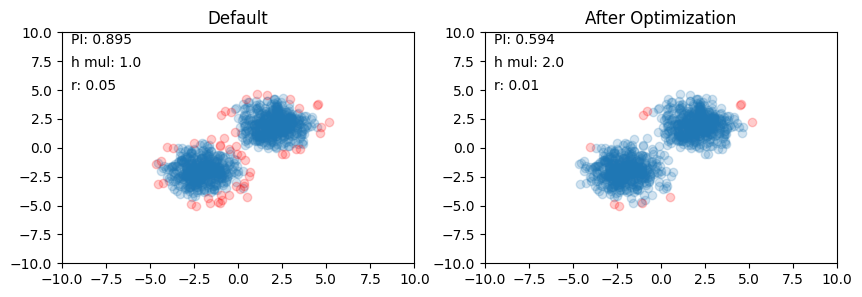

------------------------------
m=1000, (noise) a=10, a/(m+a) = 0.009901


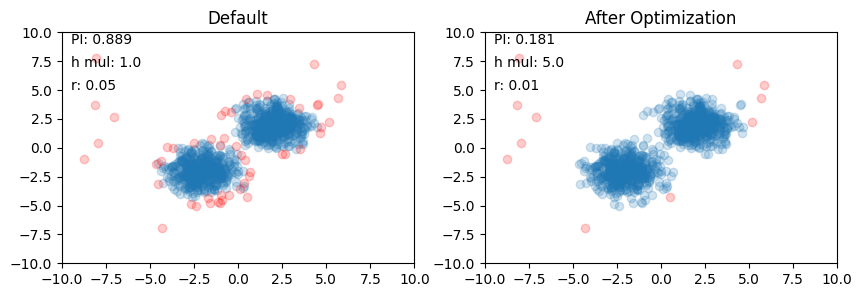

------------------------------
m=1000, (noise) a=20, a/(m+a) = 0.019608


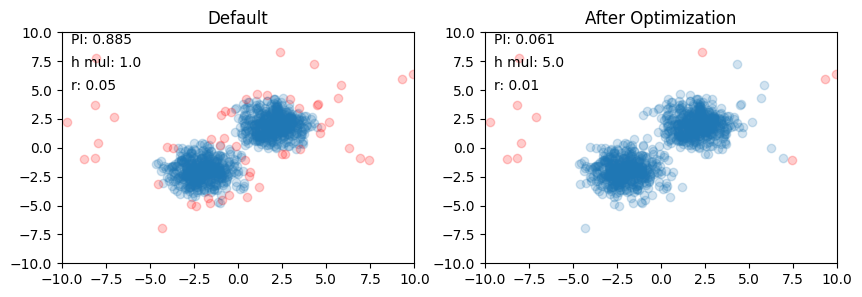

------------------------------
m=1000, (noise) a=50, a/(m+a) = 0.047619


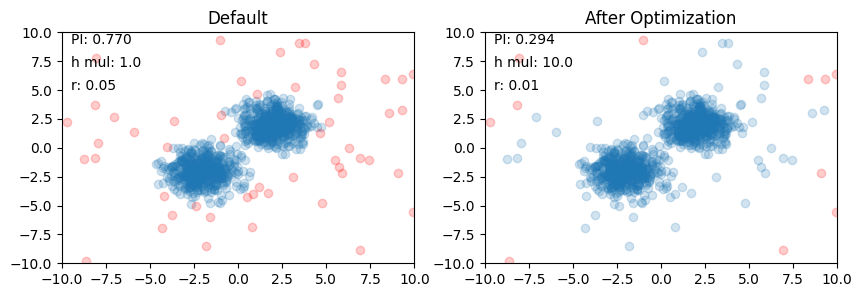

------------------------------
m=1000, (noise) a=100, a/(m+a) = 0.090909


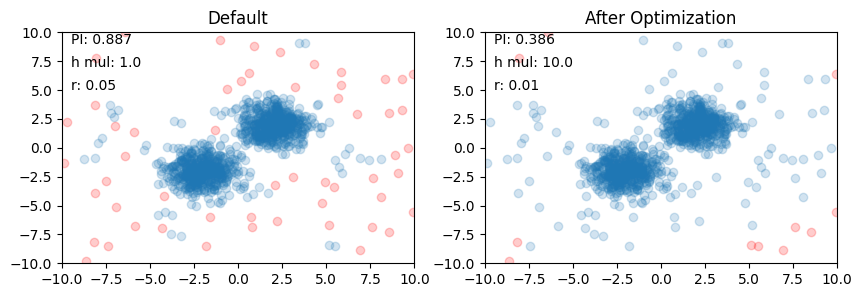

------------------------------
m=1000, (noise) a=200, a/(m+a) = 0.166667


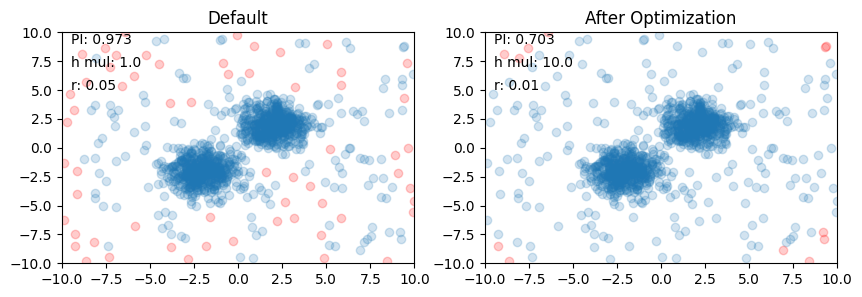

------------------------------
m=1000, (noise) a=500, a/(m+a) = 0.333333


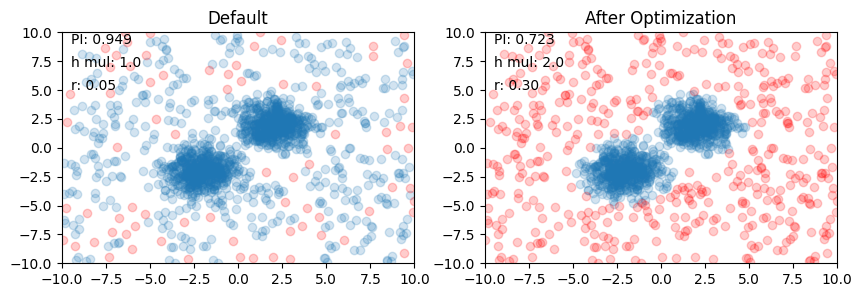

------------------------------
m=1000, (noise) a=1000, a/(m+a) = 0.500000


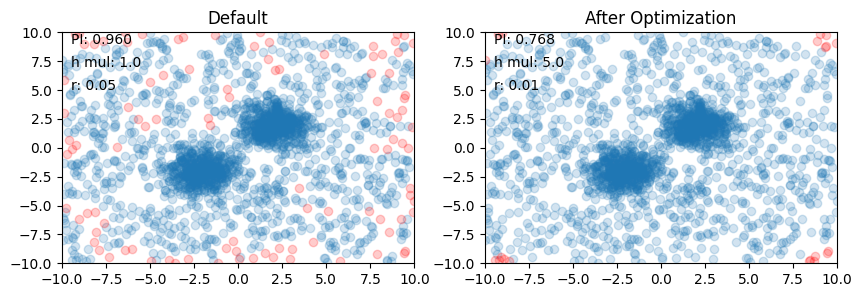

------------------------------


In [14]:
n = 2
m_train1 = 1000
    
h_mul_grid = (1.0, 0.8, 2.0, 0.6, 5.0, 0.4, 10.0, 0.2)
r_grid = (0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5)

for a in [0, 10, 20, 50, 100, 200, 500, 1000]:
    np.random.seed(0)
    print(f"m={m_train1}, (noise) a={a}, a/(m+a) = {a/(a+m_train1):.6f}")
    
    # Data
    x_train1 = np.random.multivariate_normal([-2, -2], [[1, 0], [0, 1]], size=m_train1//2)
    x_train2 = np.random.multivariate_normal([2, 2], [[1, 0], [0, 1]], size=m_train1//2)
    x_train3 = np.random.uniform(-10, 10, size=(a, n))
    x_train = np.concatenate((x_train1, x_train2, x_train3))
    
    bandwidth = direct_plugin(x_train)

    # Outliers detection
    outliers_detector0 = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth, r=0.05)
    labels_pred0 = outliers_detector0.predict(x_train)
    scores0 = outliers_detector0.kde.pdf(x_grid)
#     metric0 = pi_kf(x_train, labels_pred0, bandwidth=bandwidth)
    scores = outliers_detector0.kde.pdf(x_train)
    inliers = labels_pred0 == 0
    outliers = labels_pred0 == 1
    n_outliers = (outliers == 1).sum()
    n_inliers = (outliers == 0).sum()
    tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
    scores_out = np.sort(scores[outliers])[-tmp:]
    scores_in = np.sort(scores[inliers])[:tmp]
    metric0 = np.sum(scores_out) / np.sum(scores_in)

    # SIATKA - Dopasowanie parametrów na siatce
    
    best_metric = np.inf
    for h_mul in h_mul_grid:
        for r in r_grid:
            kde_outlier_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * h_mul, r=r)
            labels_pred = kde_outlier_detector.predict(x_train)
#             metric = pi_kf(x_train, labels_pred, bandwidth=bandwidth * h_mul)
            scores = kde_outlier_detector.kde.pdf(x_train)
            inliers = labels_pred == 0
            outliers = labels_pred == 1
            n_outliers = (outliers == 1).sum()
            n_inliers = (outliers == 0).sum()
            tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
            scores_out = np.sort(scores[outliers])[-tmp:]
            scores_in = np.sort(scores[inliers])[:tmp]
            metric = np.sum(scores_out) / np.sum(scores_in)
            if metric < best_metric:
                best_h_mul = h_mul
                best_r = r
                best_metric = metric

    # Outliers detection
    outliers_detector1 = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * best_h_mul, r=best_r)
    labels_pred1 = outliers_detector1.predict(x_train)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    
    axs[0].set_title("Default")
    axs[0].scatter(x_train[labels_pred0==0, 0], x_train[labels_pred0==0, 1], alpha=0.2)
    axs[0].scatter(x_train[labels_pred0==1, 0], x_train[labels_pred0==1, 1], c="red", alpha=0.2)
    axs[0].text(-9.5, 9, f"PI: {metric0:.3f}")
    axs[0].text(-9.5, 7, f"h mul: 1.0")
    axs[0].text(-9.5, 5, f"r: 0.05")
    axs[0].set_xlim(-10, 10)
    axs[0].set_ylim(-10, 10)
    
    axs[1].set_title("After Optimization")
    axs[1].scatter(x_train[labels_pred1==0, 0], x_train[labels_pred1==0, 1], alpha=0.2)
    axs[1].scatter(x_train[labels_pred1==1, 0], x_train[labels_pred1==1, 1], c="red", alpha=0.2)
    axs[1].text(-9.5, 9, f"PI: {best_metric:.3f}")
    axs[1].text(-9.5, 7, f"h mul: {best_h_mul:.1f}")
    axs[1].text(-9.5, 5, f"r: {best_r:.2f}")
    axs[1].set_xlim(-10, 10)
    axs[1].set_ylim(-10, 10)
    
    plt.show()

    print("-" * 30)

\newpage

## Półksiężyce

### Wersja wskaźnika uwzględniająca wszystkie elementy nietypowe

m=1000, (noise) a=0, a/(m+a) = 0.000000


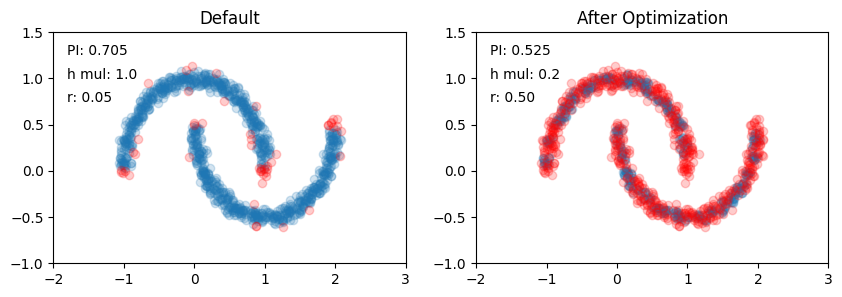

------------------------------
m=1000, (noise) a=10, a/(m+a) = 0.009901


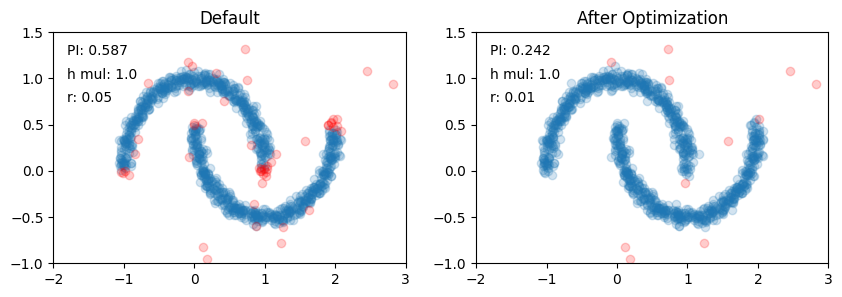

------------------------------
m=1000, (noise) a=20, a/(m+a) = 0.019608


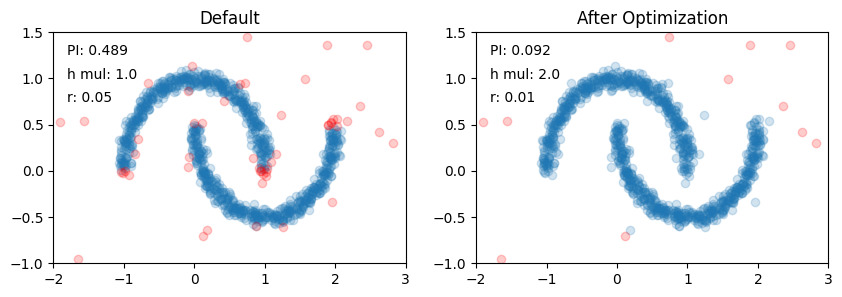

------------------------------
m=1000, (noise) a=50, a/(m+a) = 0.047619


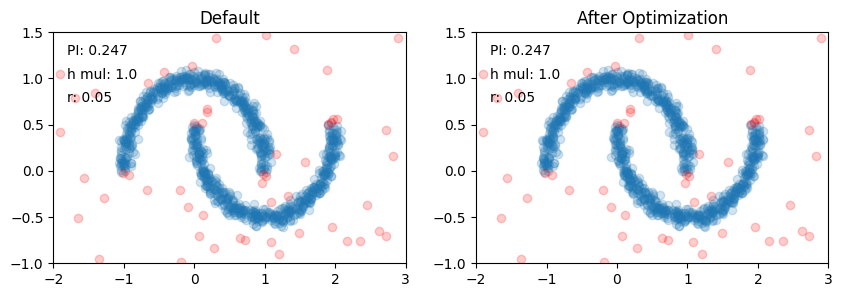

------------------------------
m=1000, (noise) a=100, a/(m+a) = 0.090909


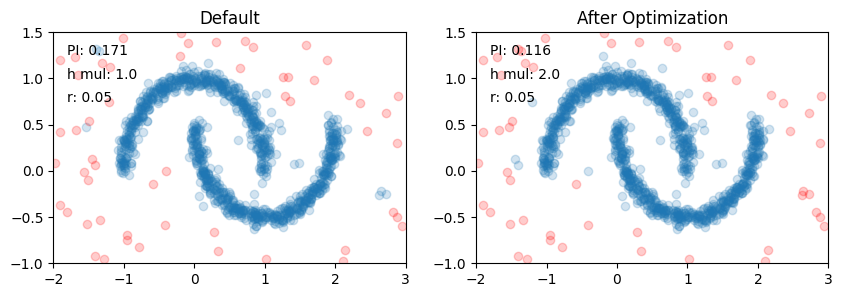

------------------------------
m=1000, (noise) a=200, a/(m+a) = 0.166667


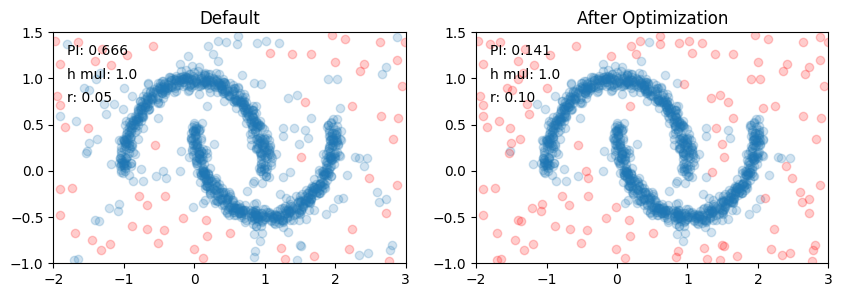

------------------------------
m=1000, (noise) a=500, a/(m+a) = 0.333333


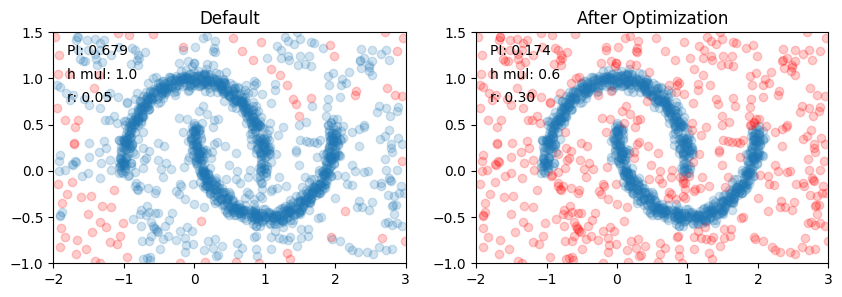

------------------------------
m=1000, (noise) a=1000, a/(m+a) = 0.500000


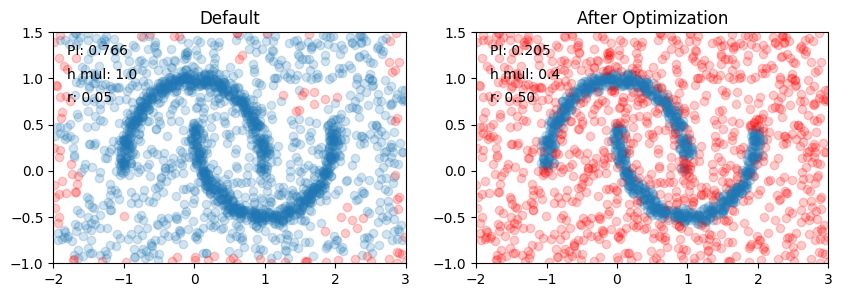

------------------------------


In [15]:
n = 2
m_train1 = 1000
    
h_mul_grid = (1.0, 0.8, 2.0, 0.6, 5.0, 0.4, 10.0, 0.2)
r_grid = (0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5)

for a in [0, 10, 20, 50, 100, 200, 500, 1000]:
    np.random.seed(0)
    print(f"m={m_train1}, (noise) a={a}, a/(m+a) = {a/(a+m_train1):.6f}")
    
    # Data
    x_train1 = make_moons(n_samples=1000, noise=0.05, random_state=0)[0]
    x_train2 = np.concatenate((np.random.uniform(-2, 3, size=(a, 1)), np.random.uniform(-1, 1.5, size=(a, 1))), axis=1)
    x_train = np.concatenate((x_train1, x_train2))
    
    bandwidth = direct_plugin(x_train)

    # Outliers detection
    outliers_detector0 = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth, r=0.05)
    labels_pred0 = outliers_detector0.predict(x_train)
    scores0 = outliers_detector0.kde.pdf(x_grid)
#     metric0 = pi_kf(x_train, labels_pred0, bandwidth=bandwidth)
    scores = outliers_detector0.kde.pdf(x_train)
    inliers = labels_pred0 == 0
    outliers = labels_pred0 == 1
    n_outliers = (outliers == 1).sum()
    scores_out = scores[outliers]
    scores_in = np.sort(scores[inliers])[:n_outliers]
    metric0 = np.sum(scores_out) / np.sum(scores_in)

    # SIATKA - Dopasowanie parametrów na siatce
    
    best_metric = np.inf
    for h_mul in h_mul_grid:
        for r in r_grid:
            kde_outlier_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * h_mul, r=r)
            labels_pred = kde_outlier_detector.predict(x_train)
#             metric = pi_kf(x_train, labels_pred, bandwidth=bandwidth * h_mul)
            scores = kde_outlier_detector.kde.pdf(x_train)
            inliers = labels_pred == 0
            outliers = labels_pred == 1
            n_outliers = (outliers == 1).sum()
            scores_out = scores[outliers]
            scores_in = np.sort(scores[inliers])[:n_outliers]
            metric = np.sum(scores_out) / np.sum(scores_in)
            if metric < best_metric:
                best_h_mul = h_mul
                best_r = r
                best_metric = metric

    # Outliers detection
    outliers_detector1 = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * best_h_mul, r=best_r)
    labels_pred1 = outliers_detector1.predict(x_train)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    
    axs[0].set_title("Default")
    axs[0].scatter(x_train[labels_pred0==0, 0], x_train[labels_pred0==0, 1], alpha=0.2)
    axs[0].scatter(x_train[labels_pred0==1, 0], x_train[labels_pred0==1, 1], c="red", alpha=0.2)
    axs[0].text(-1.8, 1.25, f"PI: {metric0:.3f}")
    axs[0].text(-1.8, 1., f"h mul: 1.0")
    axs[0].text(-1.8, 0.75, f"r: 0.05")
    axs[0].set_xlim(-2, 3)
    axs[0].set_ylim(-1, 1.5)

    axs[1].set_title("After Optimization")
    axs[1].scatter(x_train[labels_pred1==0, 0], x_train[labels_pred1==0, 1], alpha=0.2)
    axs[1].scatter(x_train[labels_pred1==1, 0], x_train[labels_pred1==1, 1], c="red", alpha=0.2)
    axs[1].text(-1.8, 1.25, f"PI: {best_metric:.3f}")
    axs[1].text(-1.8, 1., f"h mul: {best_h_mul:.1f}")
    axs[1].text(-1.8, 0.75, f"r: {best_r:.2f}")
    axs[1].set_xlim(-2, 3)
    axs[1].set_ylim(-1, 1.5)
    
    plt.show()

    print("-" * 30)

\newpage

### Wersja wskaźnika uwzględniająca 1% elementów nietypowych

m=1000, (noise) a=0, a/(m+a) = 0.000000


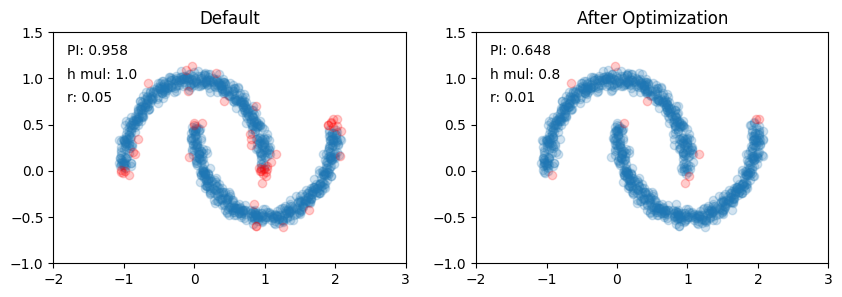

------------------------------
m=1000, (noise) a=10, a/(m+a) = 0.009901


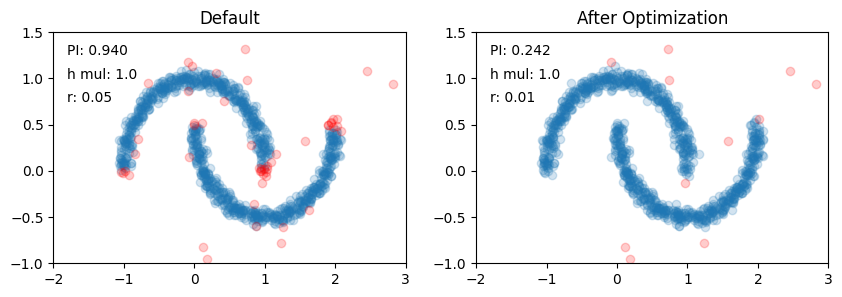

------------------------------
m=1000, (noise) a=20, a/(m+a) = 0.019608


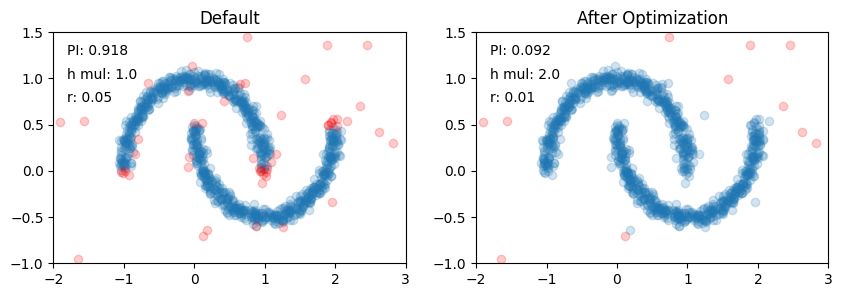

------------------------------
m=1000, (noise) a=50, a/(m+a) = 0.047619


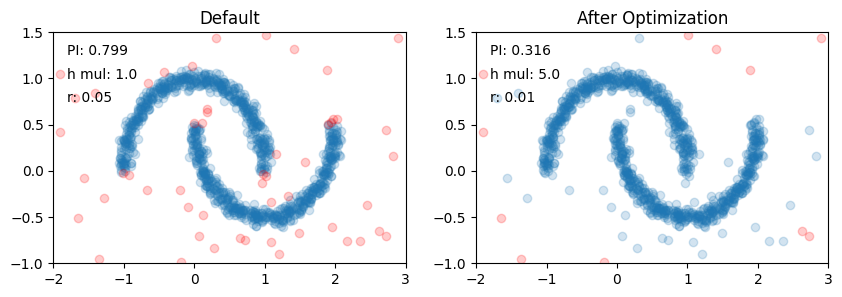

------------------------------
m=1000, (noise) a=100, a/(m+a) = 0.090909


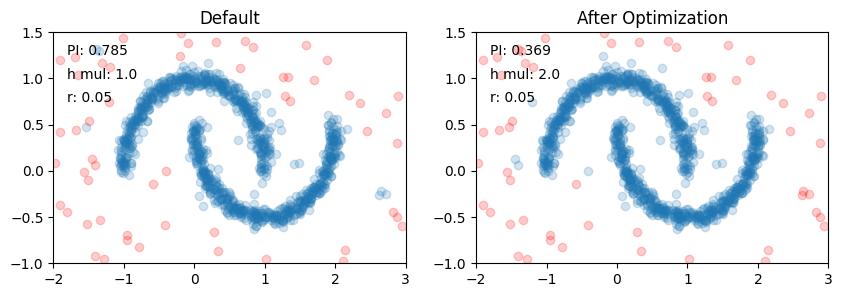

------------------------------
m=1000, (noise) a=200, a/(m+a) = 0.166667


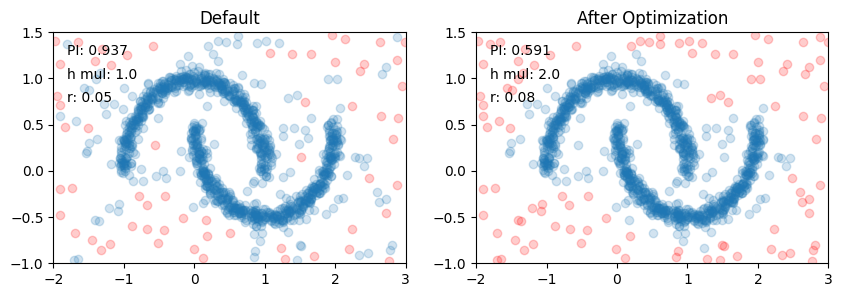

------------------------------
m=1000, (noise) a=500, a/(m+a) = 0.333333


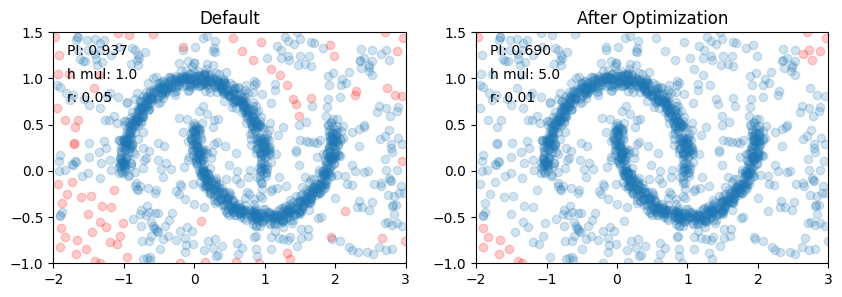

------------------------------
m=1000, (noise) a=1000, a/(m+a) = 0.500000


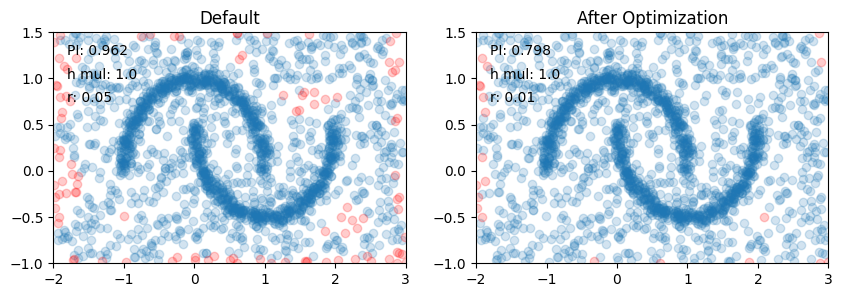

------------------------------


In [16]:
n = 2
m_train1 = 1000
    
h_mul_grid = (1.0, 0.8, 2.0, 0.6, 5.0, 0.4, 10.0, 0.2)
r_grid = (0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5)

for a in [0, 10, 20, 50, 100, 200, 500, 1000]:
    np.random.seed(0)
    print(f"m={m_train1}, (noise) a={a}, a/(m+a) = {a/(a+m_train1):.6f}")
    
    # Data
    x_train1 = make_moons(n_samples=1000, noise=0.05, random_state=0)[0]
    x_train2 = np.concatenate((np.random.uniform(-2, 3, size=(a, 1)), np.random.uniform(-1, 1.5, size=(a, 1))), axis=1)
    x_train = np.concatenate((x_train1, x_train2))
    
    bandwidth = direct_plugin(x_train)

    # Outliers detection
    outliers_detector0 = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth, r=0.05)
    labels_pred0 = outliers_detector0.predict(x_train)
    scores0 = outliers_detector0.kde.pdf(x_grid)
#     metric0 = pi_kf(x_train, labels_pred0, bandwidth=bandwidth)
    scores = outliers_detector0.kde.pdf(x_train)
    inliers = labels_pred0 == 0
    outliers = labels_pred0 == 1
    n_outliers = (outliers == 1).sum()
    n_inliers = (outliers == 0).sum()
    tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
    scores_out = np.sort(scores[outliers])[-tmp:]
    scores_in = np.sort(scores[inliers])[:tmp]
    metric0 = np.sum(scores_out) / np.sum(scores_in)

    # SIATKA - Dopasowanie parametrów na siatce
    
    best_metric = np.inf
    for h_mul in h_mul_grid:
        for r in r_grid:
            kde_outlier_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * h_mul, r=r)
            labels_pred = kde_outlier_detector.predict(x_train)
#             metric = pi_kf(x_train, labels_pred, bandwidth=bandwidth * h_mul)
            scores = kde_outlier_detector.kde.pdf(x_train)
            inliers = labels_pred == 0
            outliers = labels_pred == 1
            n_outliers = (outliers == 1).sum()
            n_inliers = (outliers == 0).sum()
            tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
            scores_out = np.sort(scores[outliers])[-tmp:]
            scores_in = np.sort(scores[inliers])[:tmp]
            metric = np.sum(scores_out) / np.sum(scores_in)
            if metric < best_metric:
                best_h_mul = h_mul
                best_r = r
                best_metric = metric

    # Outliers detection
    outliers_detector1 = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth * best_h_mul, r=best_r)
    labels_pred1 = outliers_detector1.predict(x_train)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    
    axs[0].set_title("Default")
    axs[0].scatter(x_train[labels_pred0==0, 0], x_train[labels_pred0==0, 1], alpha=0.2)
    axs[0].scatter(x_train[labels_pred0==1, 0], x_train[labels_pred0==1, 1], c="red", alpha=0.2)
    axs[0].text(-1.8, 1.25, f"PI: {metric0:.3f}")
    axs[0].text(-1.8, 1., f"h mul: 1.0")
    axs[0].text(-1.8, 0.75, f"r: 0.05")
    axs[0].set_xlim(-2, 3)
    axs[0].set_ylim(-1, 1.5)

    axs[1].set_title("After Optimization")
    axs[1].scatter(x_train[labels_pred1==0, 0], x_train[labels_pred1==0, 1], alpha=0.2)
    axs[1].scatter(x_train[labels_pred1==1, 0], x_train[labels_pred1==1, 1], c="red", alpha=0.2)
    axs[1].text(-1.8, 1.25, f"PI: {best_metric:.3f}")
    axs[1].text(-1.8, 1., f"h mul: {best_h_mul:.1f}")
    axs[1].text(-1.8, 0.75, f"r: {best_r:.2f}")
    axs[1].set_xlim(-2, 3)
    axs[1].set_ylim(-1, 1.5)
    
    plt.show()

    print("-" * 30)